In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference, selection_rate, true_positive_rate, false_positive_rate, false_negative_rate
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

# Load the cleaned dataset
data = pd.read_csv('cleaned_communities_crime_data.csv')

# Define the target and features
target = 'ViolentCrimesPerPop'
features = data.drop(columns=[target])
sensitive_features = ['racePctWhite', 'racepctblack']

# Binarize the target variable based on the mean
threshold = data[target].mean()
data['ViolentCrimesPerPop_binary'] = (data[target] > threshold).astype(int)

# Discretize the sensitive features
data['racePctWhite_bin'] = pd.cut(data['racePctWhite'], bins=5, labels=False)
data['racepctblack_bin'] = pd.cut(data['racepctblack'], bins=5, labels=False)


In [2]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, data['ViolentCrimesPerPop_binary'], test_size=0.2, random_state=42
)

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict using the trained model
y_pred = rf_model.predict(X_test)
y_pred_binary = (y_pred > threshold).astype(int)

# Define a function to calculate different metrics
def compute_metrics(y_true, y_pred):
    metrics = {
        'mean_absolute_error': mean_absolute_error(y_true, y_pred),
        'root_mean_squared_error': mean_squared_error(y_true, y_pred, squared=False),
        'r2_score': r2_score(y_true, y_pred),
        'selection_rate': selection_rate(y_true, y_pred),
        'false_positive_rate': false_positive_rate(y_true, y_pred),
        'false_negative_rate': false_negative_rate(y_true, y_pred),
        'true_positive_rate': true_positive_rate(y_true, y_pred)
    }
    return metrics

# Compute metrics for different groups
metrics = MetricFrame(
    metrics=compute_metrics,
    y_true=y_test,
    y_pred=y_pred_binary,
    sensitive_features=data.loc[X_test.index, ['racePctWhite_bin', 'racepctblack_bin']]
)

# Print the overall metrics
print("Overall Metrics:")
print(metrics.overall)

# Print metrics by sensitive feature groups
print("\nMetrics by Sensitive Feature Groups:")
print(metrics.by_group)


Overall Metrics:
{'mean_absolute_error': 0.7252747252747253, 'root_mean_squared_error': 0.8516306272526402, 'r2_score': -2.6399999999999992, 'selection_rate': 1.0, 'false_positive_rate': 1.0, 'false_negative_rate': 0.0, 'true_positive_rate': 1.0}

Metrics by Sensitive Feature Groups:
racePctWhite_bin  racepctblack_bin
0                 0                                                                 NaN
                  1                                                                 NaN
                  2                                                                 NaN
                  3                                                                 NaN
                  4                   {'mean_absolute_error': 0.0, 'root_mean_square...
1                 0                                                                 NaN
                  1                   {'mean_absolute_error': 0.0, 'root_mean_square...
                  2                   {'mean_absolute_error': 0.

C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the ro

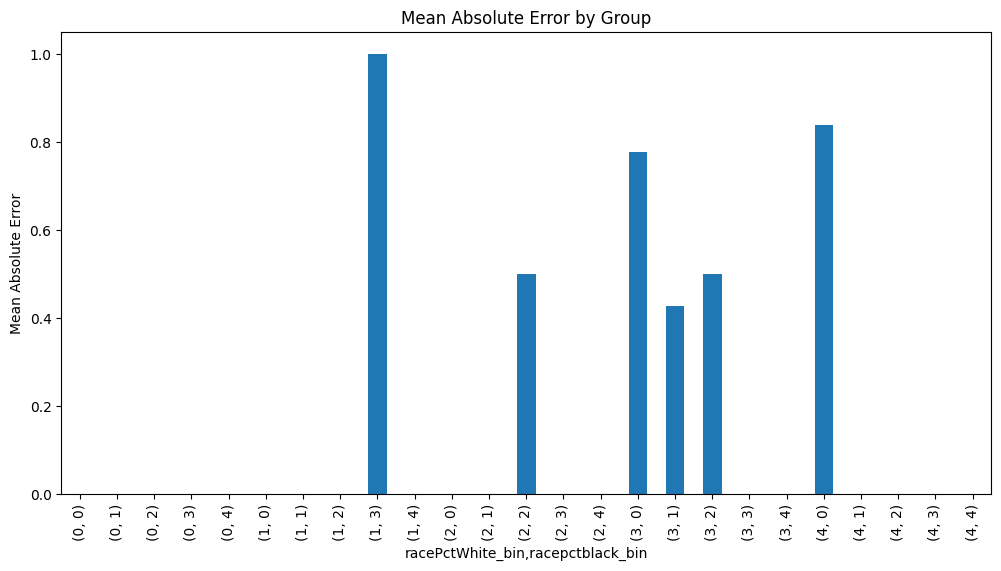

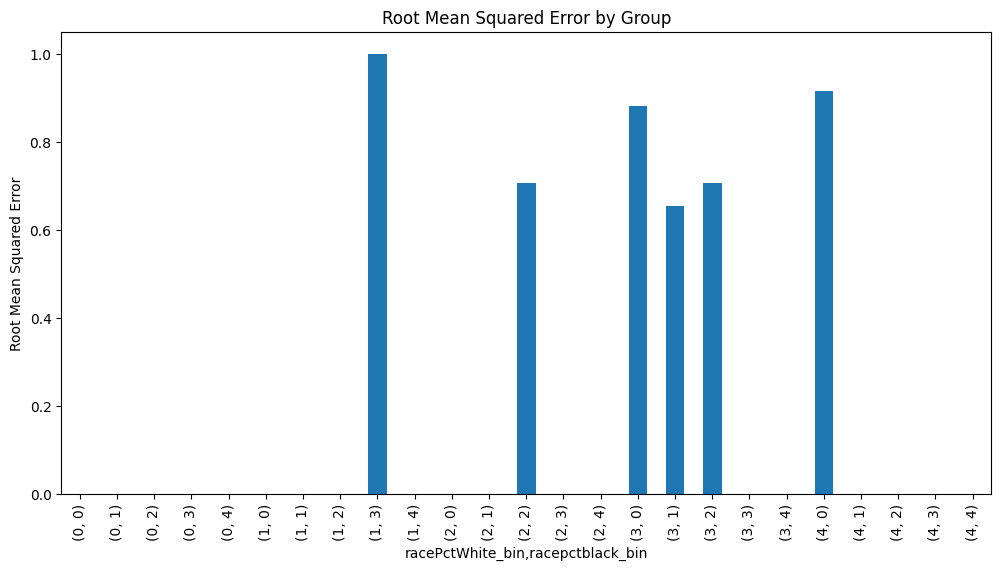

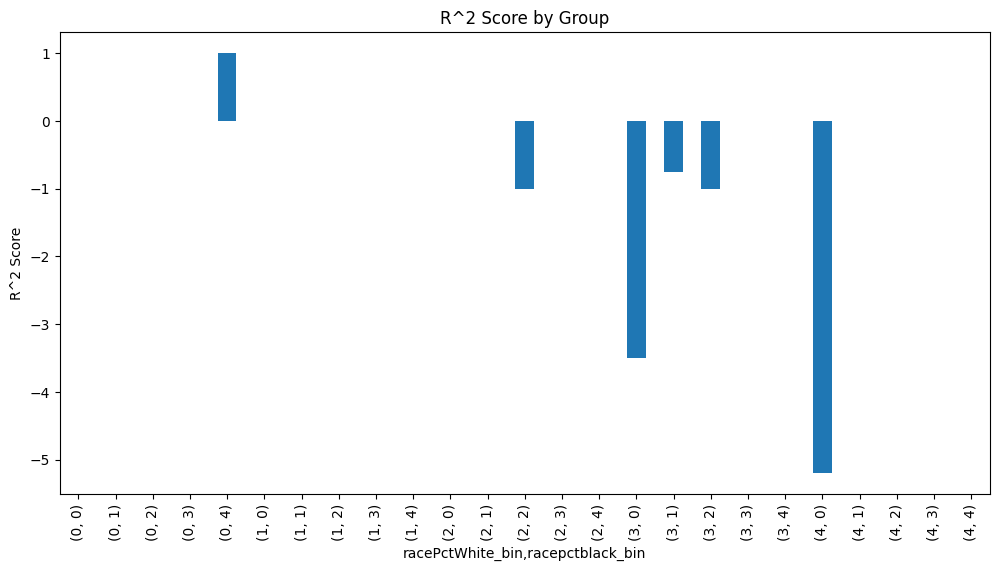

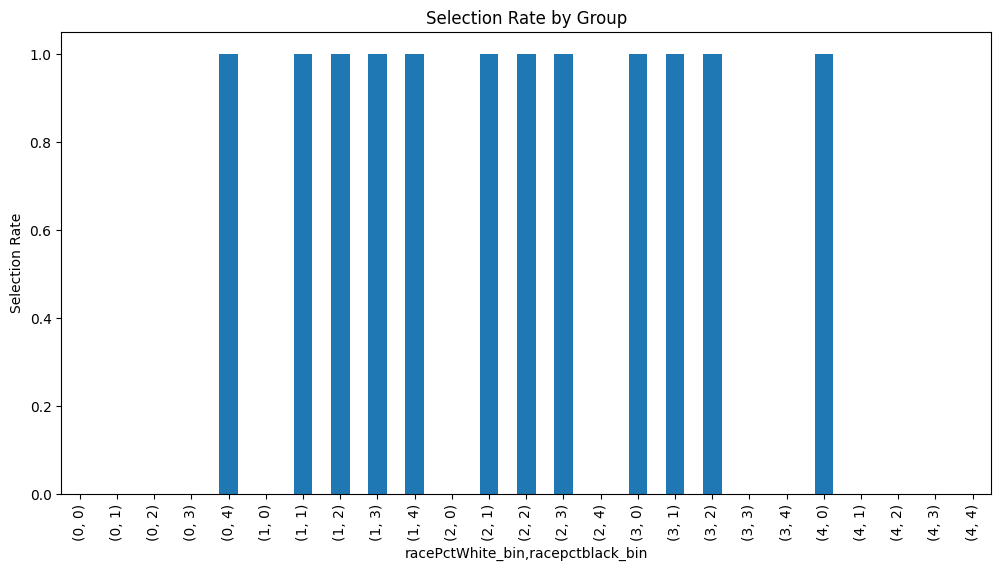

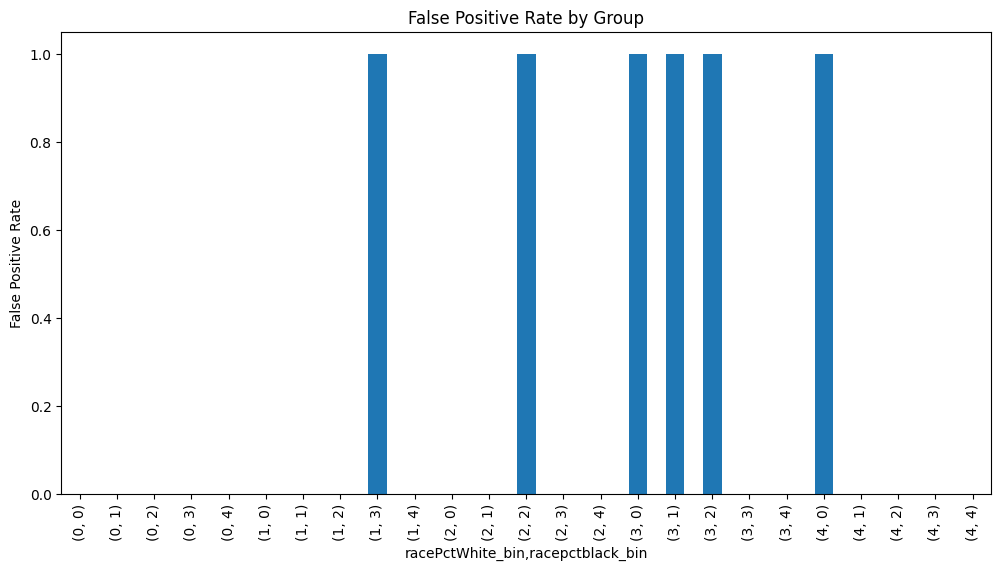

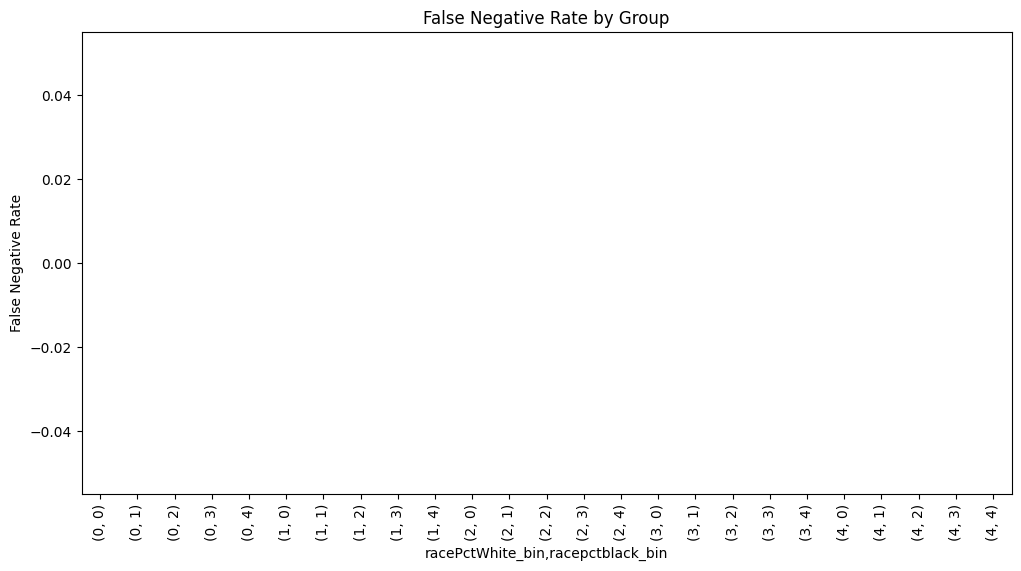

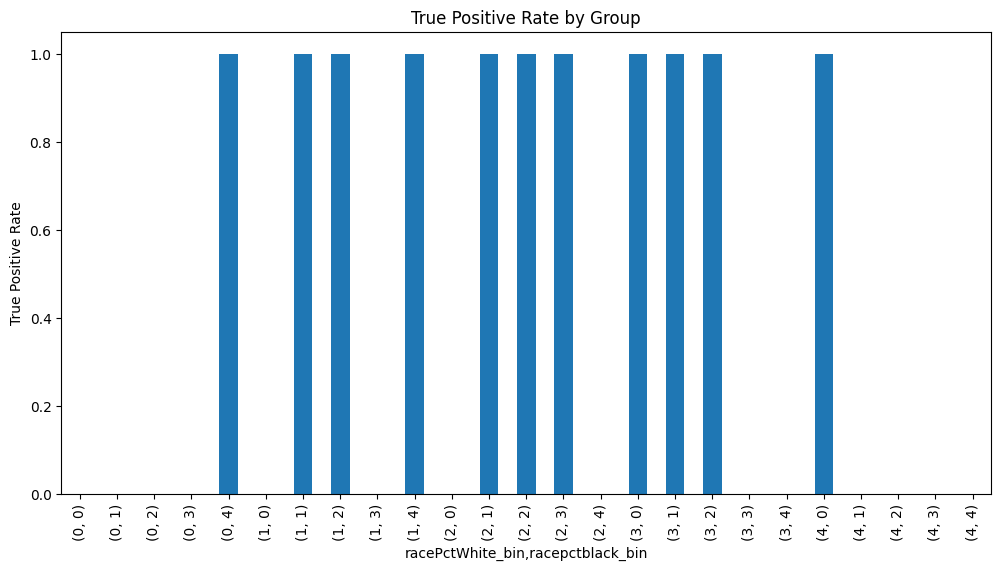

In [3]:
# Extract metrics for visualization
metrics_by_group = metrics.by_group.apply(pd.Series)
mae = metrics_by_group['mean_absolute_error']
rmse = metrics_by_group['root_mean_squared_error']
r2 = metrics_by_group['r2_score']
selection_rate = metrics_by_group['selection_rate']
fpr = metrics_by_group['false_positive_rate']
fnr = metrics_by_group['false_negative_rate']
tpr = metrics_by_group['true_positive_rate']

# Plot Mean Absolute Error by Group
mae.plot(kind='bar', figsize=(12, 6), title='Mean Absolute Error by Group')
plt.ylabel('Mean Absolute Error')
plt.show()

# Plot Root Mean Squared Error by Group
rmse.plot(kind='bar', figsize=(12, 6), title='Root Mean Squared Error by Group')
plt.ylabel('Root Mean Squared Error')
plt.show()

# Plot R^2 Score by Group
r2.plot(kind='bar', figsize=(12, 6), title='R^2 Score by Group')
plt.ylabel('R^2 Score')
plt.show()

# Plot Selection Rate by Group
selection_rate.plot(kind='bar', figsize=(12, 6), title='Selection Rate by Group')
plt.ylabel('Selection Rate')
plt.show()

# Plot False Positive Rate by Group
fpr.plot(kind='bar', figsize=(12, 6), title='False Positive Rate by Group')
plt.ylabel('False Positive Rate')
plt.show()

# Plot False Negative Rate by Group
fnr.plot(kind='bar', figsize=(12, 6), title='False Negative Rate by Group')
plt.ylabel('False Negative Rate')
plt.show()

# Plot True Positive Rate by Group
tpr.plot(kind='bar', figsize=(12, 6), title='True Positive Rate by Group')
plt.ylabel('True Positive Rate')
plt.show()


In [4]:
# Custom Metric Functions
def false_positive_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fp / (fp + tn)

def false_negative_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fn / (fn + tp)

def selection_rate_custom(y_pred):
    return np.mean(y_pred)

def false_positive_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(false_positive_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)

def false_negative_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(false_negative_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)

def selection_rate_difference(y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(selection_rate_custom(y_pred[mask]))
    return np.max(rates) - np.min(rates)


C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_7336\1912939681.py:4: RuntimeWarning: invalid value encountered in longlong_scalars
  return fp / (fp + tn)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_7336\2382023145.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_white = df.groupby('racePctWhite_bin').apply(lambda x: pd.Series({
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_7336\2382023145.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping 

Demographic Parity Difference: 0.0
Equalized Odds Difference: 1.0
False Positive Rate Difference: nan
False Negative Rate Difference: 0.0
Selection Rate Difference: 0.0

Additional Metrics by 'racePctWhite_bin':
                  accuracy  precision  recall        f1
racePctWhite_bin                                       
0                 1.000000   1.000000     1.0  1.000000
1                 0.600000   0.600000     1.0  0.750000
2                 0.750000   0.750000     1.0  0.857143
3                 0.388889   0.388889     1.0  0.560000
4                 0.161290   0.161290     1.0  0.277778

Additional Metrics by 'racepctblack_bin':
                  accuracy  precision  recall        f1
racepctblack_bin                                       
0                 0.169014   0.169014     1.0  0.289157
1                 0.666667   0.666667     1.0  0.800000
2                 0.600000   0.600000     1.0  0.750000
3                 0.333333   0.333333     1.0  0.500000
4                

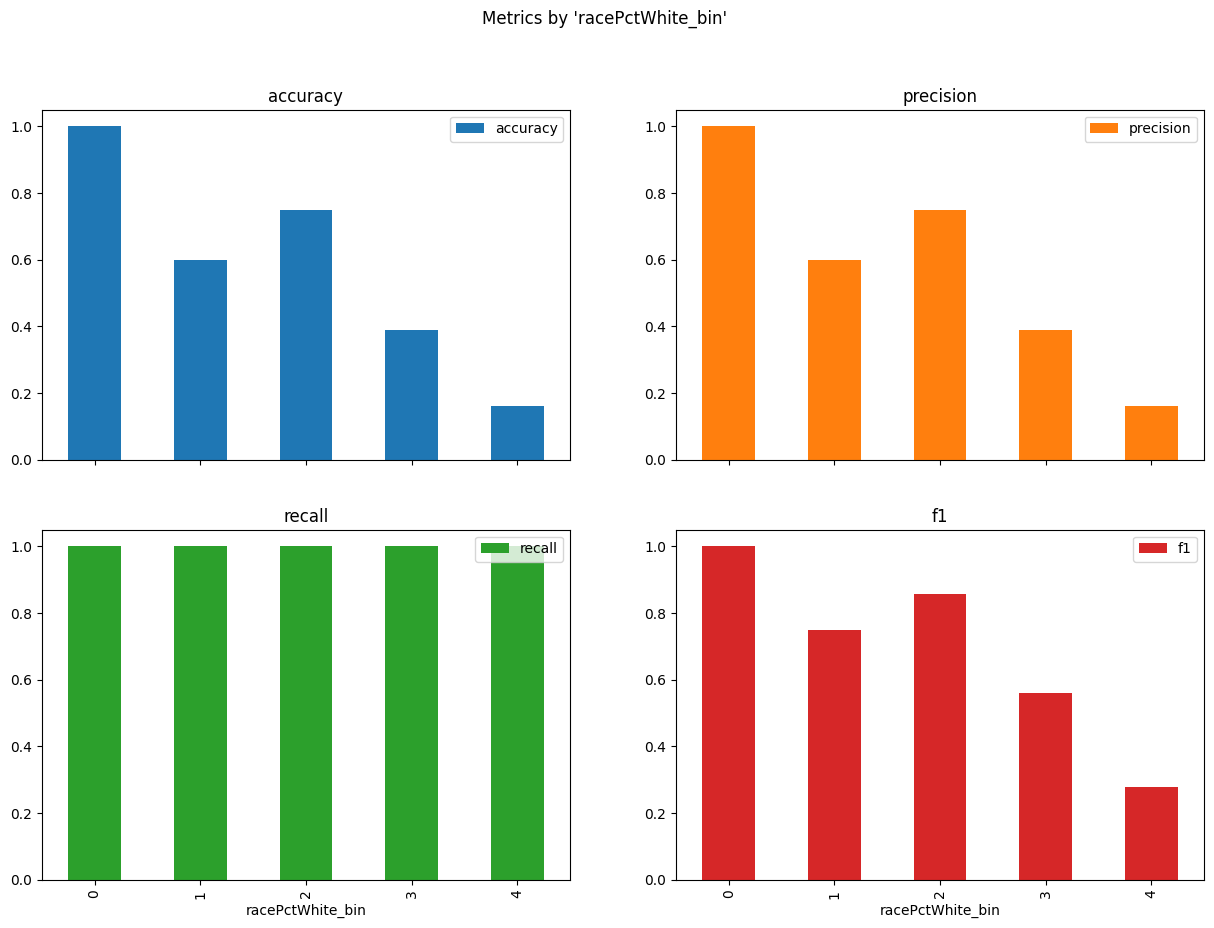

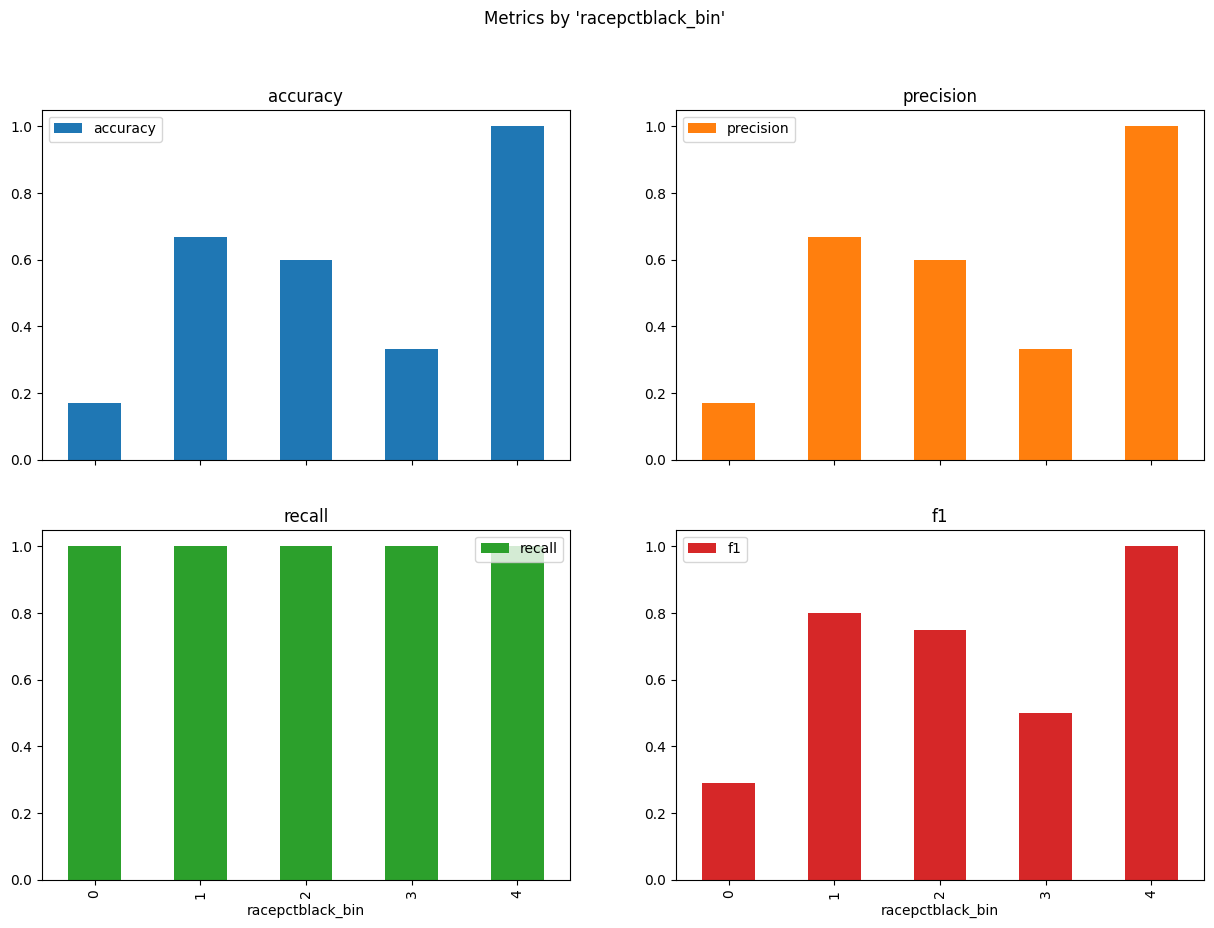

In [5]:
# Calculate fairness metrics
dpd = demographic_parity_difference(y_test, y_pred_binary, sensitive_features=data.loc[X_test.index, 'racePctWhite_bin'])
eod = equalized_odds_difference(y_test, y_pred_binary, sensitive_features=data.loc[X_test.index, 'racePctWhite_bin'])
fprd = false_positive_rate_difference(y_test, y_pred_binary, sensitive_features=data.loc[X_test.index, 'racePctWhite_bin'])
fnrd = false_negative_rate_difference(y_test, y_pred_binary, sensitive_features=data.loc[X_test.index, 'racePctWhite_bin'])
srd = selection_rate_difference(y_pred_binary, sensitive_features=data.loc[X_test.index, 'racePctWhite_bin'])

print(f"Demographic Parity Difference: {dpd}")
print(f"Equalized Odds Difference: {eod}")
print(f"False Positive Rate Difference: {fprd}")
print(f"False Negative Rate Difference: {fnrd}")
print(f"Selection Rate Difference: {srd}")

# Create a DataFrame for easier analysis
df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred_binary,
    'racePctWhite_bin': data.loc[X_test.index, 'racePctWhite_bin'],
    'racepctblack_bin': data.loc[X_test.index, 'racepctblack_bin']
})

# Calculate additional metrics for each subgroup
grouped_white = df.groupby('racePctWhite_bin').apply(lambda x: pd.Series({
    'accuracy': accuracy_score(x['y_true'], x['y_pred']),
    'precision': precision_score(x['y_true'], x['y_pred']),
    'recall': recall_score(x['y_true'], x['y_pred']),
    'f1': f1_score(x['y_true'], x['y_pred'])
}))

print("\nAdditional Metrics by 'racePctWhite_bin':")
print(grouped_white)

grouped_black = df.groupby('racepctblack_bin').apply(lambda x: pd.Series({
    'accuracy': accuracy_score(x['y_true'], x['y_pred']),
    'precision': precision_score(x['y_true'], x['y_pred']),
    'recall': recall_score(x['y_true'], x['y_pred']),
    'f1': f1_score(x['y_true'], x['y_pred'])
}))

print("\nAdditional Metrics by 'racepctblack_bin':")
print(grouped_black)

# Plot additional metrics by 'racePctWhite_bin'
grouped_white.plot(kind='bar', subplots=True, layout=(2, 2), figsize=(15, 10), title="Metrics by 'racePctWhite_bin'")
plt.show()

# Plot additional metrics by 'racepctblack_bin'
grouped_black.plot(kind='bar', subplots=True, layout=(2, 2), figsize=(15, 10), title="Metrics by 'racepctblack_bin'")
plt.show()



C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_7336\1168481752.py:6: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tn)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_7336\1912939681.py:4: RuntimeWarning: invalid value encountered in longlong_scalars
  return fp / (fp + tn)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_7336\1168481752.py:6: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tn)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_7336\1168481752.py:10: RuntimeWarning: invalid value encountered in longlong_scalars
  return tn / (tn + fp)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_7336\1168481752.py:6: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tn)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_7336\1168481752.py:6: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tn)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_7336\1168481752.py:6: Runtime


Additional Metrics by Sensitive Feature Groups:
                  false_positive_rate  false_negative_rate  \
racePctWhite_bin                                             
0                                 NaN                  0.0   
1                                 1.0                  0.0   
2                                 1.0                  0.0   
3                                 1.0                  0.0   
4                                 1.0                  0.0   

                  false_omission_rate  true_negative_rate  
racePctWhite_bin                                           
0                                 NaN                 NaN  
1                                 NaN                 0.0  
2                                 NaN                 0.0  
3                                 NaN                 0.0  
4                                 NaN                 0.0  


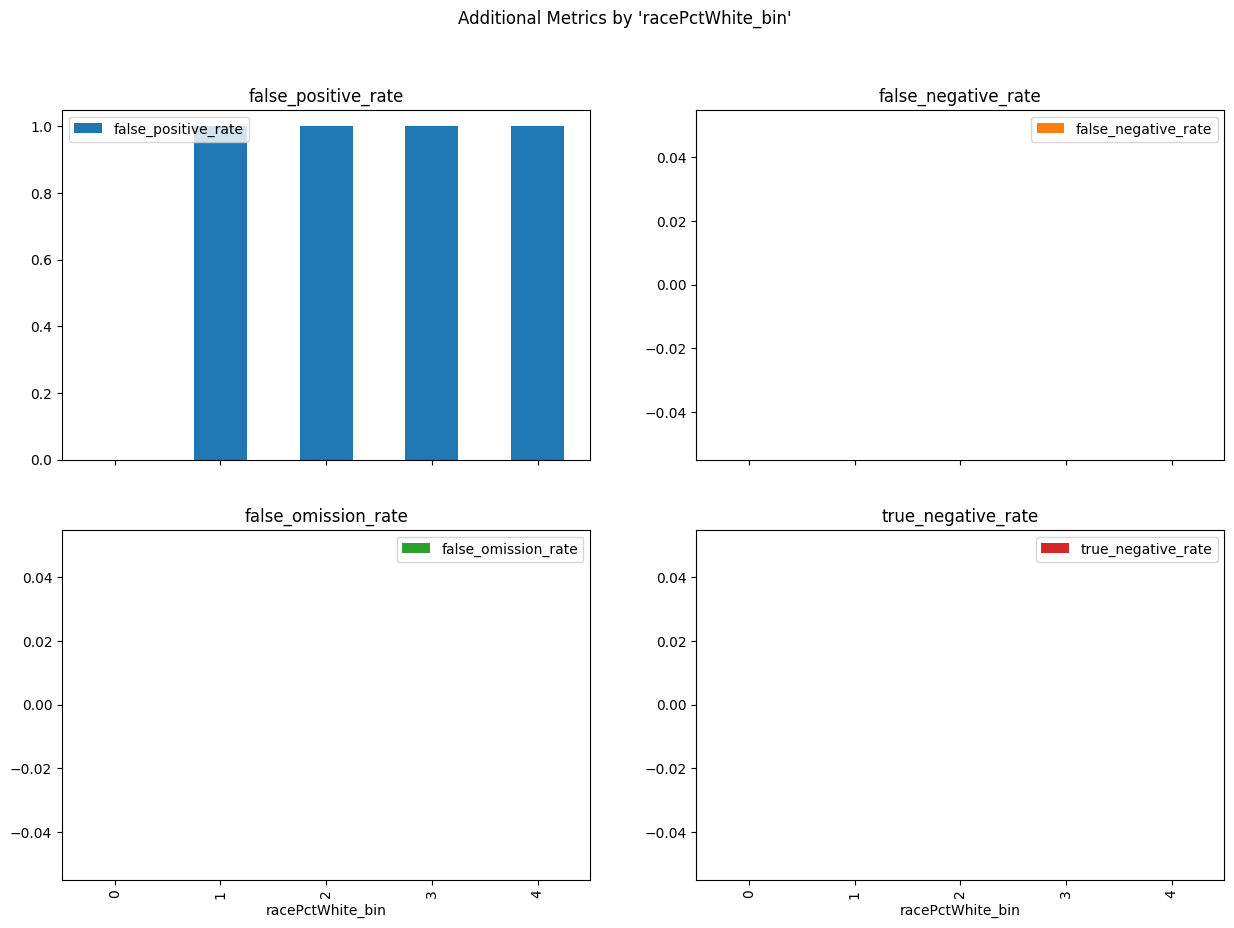


Summary of Fairness Metrics:
Demographic Parity Difference: 0.0
Equalized Odds Difference: 1.0
False Positive Rate Difference: nan
False Negative Rate Difference: 0.0
Selection Rate Difference: 0.0
False Omission Rate Difference: nan
True Negative Rate Difference: 0.0

Additional Metrics by 'racepctblack_bin':
                  false_positive_rate  false_negative_rate  \
racepctblack_bin                                             
0                                 1.0                  0.0   
1                                 1.0                  0.0   
2                                 1.0                  0.0   
3                                 1.0                  0.0   
4                                 NaN                  0.0   

                  false_omission_rate  true_negative_rate  
racepctblack_bin                                           
0                                 NaN                 0.0  
1                                 NaN                 0.0  
2           

C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_7336\1168481752.py:6: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tn)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_7336\1168481752.py:6: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tn)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_7336\1168481752.py:6: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tn)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_7336\1168481752.py:6: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tn)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_7336\1168481752.py:6: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tn)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_7336\1168481752.py:6: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tn)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_7336\1912939681.py:4: RuntimeW

In [6]:
from fairlearn.metrics import false_negative_rate, true_positive_rate, false_positive_rate, selection_rate

# Define additional custom metrics
def false_omission_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fn / (fn + tn)

def true_negative_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return tn / (tn + fp)

# Calculate additional fairness metrics
for_custom_metrics = {
    'false_positive_rate': false_positive_rate_custom,
    'false_negative_rate': false_negative_rate_custom,
    'false_omission_rate': false_omission_rate_custom,
    'true_negative_rate': true_negative_rate_custom
}

additional_metrics = MetricFrame(
    metrics=for_custom_metrics,
    y_true=y_test,
    y_pred=y_pred_binary,
    sensitive_features=data.loc[X_test.index, 'racePctWhite_bin']
)

# Print additional metrics by group
print("\nAdditional Metrics by Sensitive Feature Groups:")
print(additional_metrics.by_group)

# Plot additional metrics
additional_metrics.by_group.plot(kind='bar', subplots=True, layout=(2, 2), figsize=(15, 10), title="Additional Metrics by 'racePctWhite_bin'")
plt.show()

# Summarize all fairness metrics
summary_metrics = {
    'Demographic Parity Difference': dpd,
    'Equalized Odds Difference': eod,
    'False Positive Rate Difference': fprd,
    'False Negative Rate Difference': fnrd,
    'Selection Rate Difference': srd,
    'False Omission Rate Difference': false_omission_rate_custom(y_test, y_pred_binary),
    'True Negative Rate Difference': true_negative_rate_custom(y_test, y_pred_binary)
}

print("\nSummary of Fairness Metrics:")
for metric, value in summary_metrics.items():
    print(f"{metric}: {value}")

# Calculate fairness metrics for 'racepctblack_bin'
additional_metrics_black = MetricFrame(
    metrics=for_custom_metrics,
    y_true=y_test,
    y_pred=y_pred_binary,
    sensitive_features=data.loc[X_test.index, 'racepctblack_bin']
)

# Print additional metrics by group for 'racepctblack_bin'
print("\nAdditional Metrics by 'racepctblack_bin':")
print(additional_metrics_black.by_group)


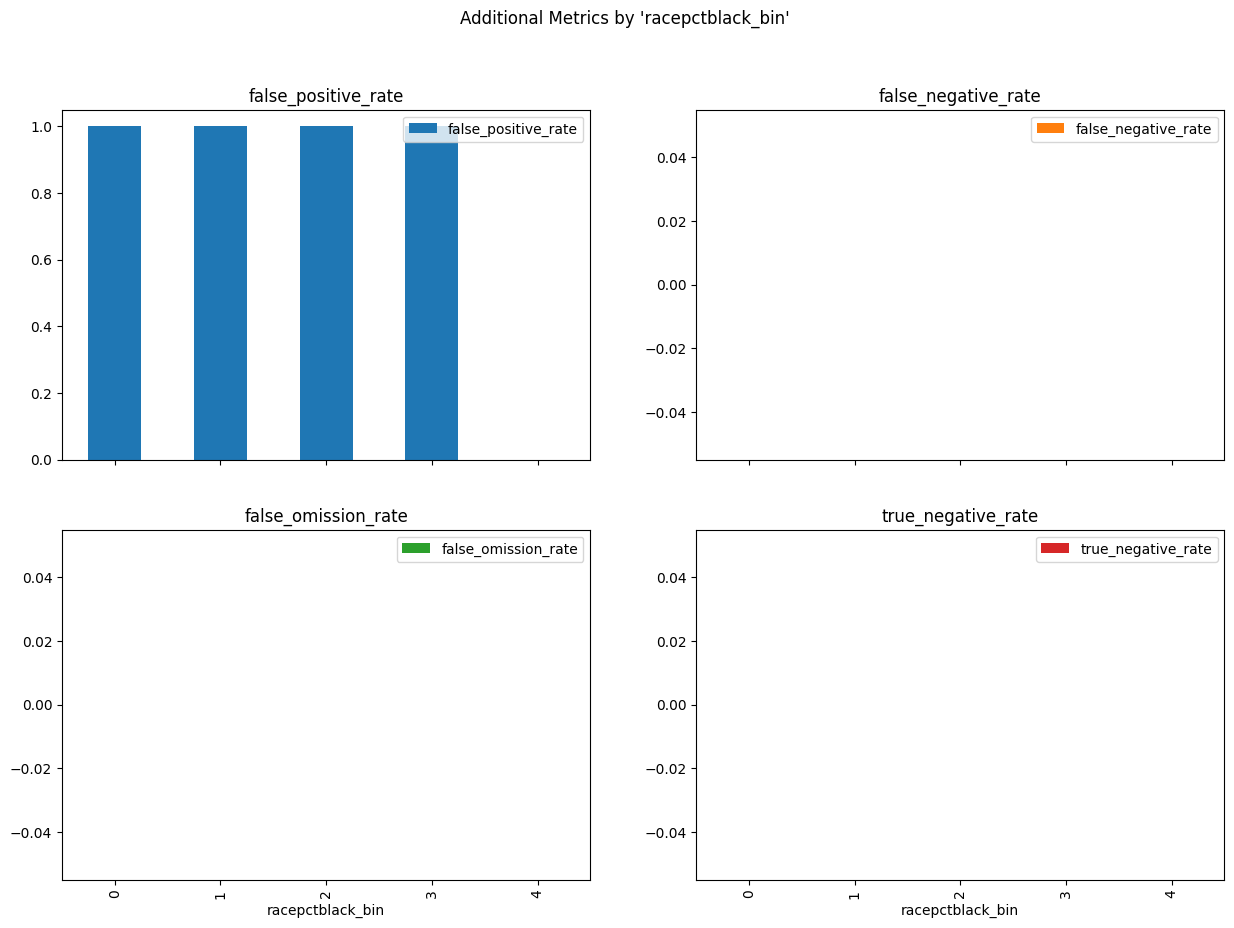

Overall Metrics after Reweighing:
{'mean_absolute_error': 0.18681318681318682, 'root_mean_squared_error': 0.4322189107537832, 'r2_score': 0.062424242424242604, 'selection_rate': 0.2857142857142857, 'false_positive_rate': 0.13636363636363635, 'false_negative_rate': 0.32, 'true_positive_rate': 0.68}

Metrics by Sensitive Feature Groups after Reweighing:
racePctWhite_bin  racepctblack_bin
0                 0                                                                 NaN
                  1                                                                 NaN
                  2                                                                 NaN
                  3                                                                 NaN
                  4                   {'mean_absolute_error': 0.0, 'root_mean_square...
1                 0                                                                 NaN
                  1                   {'mean_absolute_error': 0.0, 'root_mean_squar

C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the ro

In [7]:
# Plot additional metrics for 'racepctblack_bin'
additional_metrics_black.by_group.plot(kind='bar', subplots=True, layout=(2, 2), figsize=(15, 10), title="Additional Metrics by 'racepctblack_bin'")
plt.show()

# Manually perform reweighing
def compute_sample_weights(data, sensitive_features, target):
    df = data.copy()
    df['weight'] = 1.0
    
    # Calculate the prevalence of each group
    group_counts = df.groupby(sensitive_features).size()
    total_count = len(df)
    
    for group, count in group_counts.items():
        group_weight = total_count / (len(group_counts) * count)
        df.loc[(df[sensitive_features] == group).all(axis=1), 'weight'] = group_weight
    
    return df['weight']

# Compute sample weights for training data
sample_weights = compute_sample_weights(data.loc[X_train.index], ['racePctWhite_bin', 'racepctblack_bin'], 'ViolentCrimesPerPop_binary')

# Train a Random Forest model on the reweighed data
rf_model_rw = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_rw.fit(X_train, y_train, sample_weight=sample_weights)

# Predict using the trained model
y_pred_rw = rf_model_rw.predict(X_test)

# Compute metrics for different groups
metrics_rw = MetricFrame(
    metrics=compute_metrics,
    y_true=y_test,
    y_pred=y_pred_rw,
    sensitive_features=data.loc[X_test.index, ['racePctWhite_bin', 'racepctblack_bin']]
)

# Print the overall metrics
print("Overall Metrics after Reweighing:")
print(metrics_rw.overall)

# Print metrics by sensitive feature groups
print("\nMetrics by Sensitive Feature Groups after Reweighing:")
print(metrics_rw.by_group)


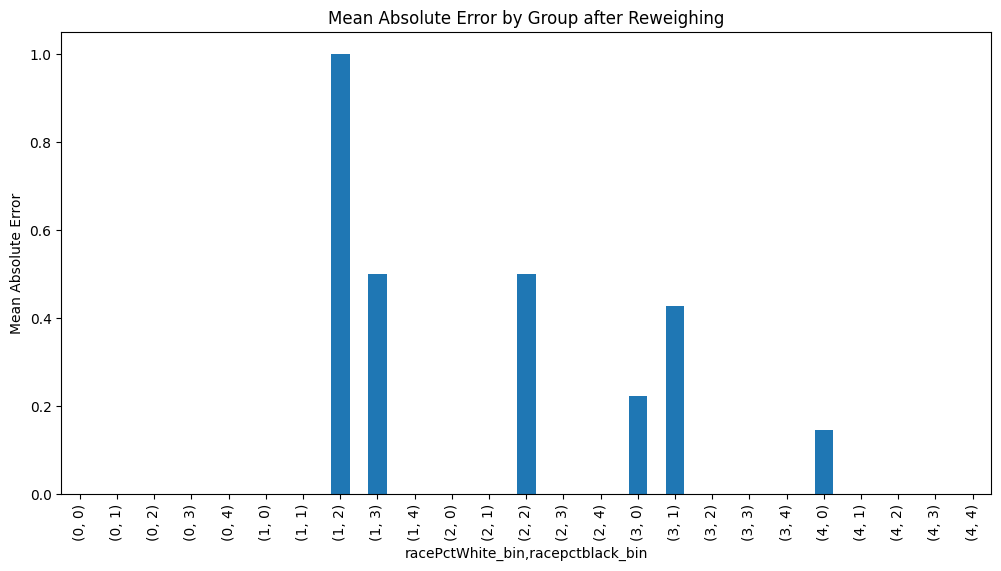

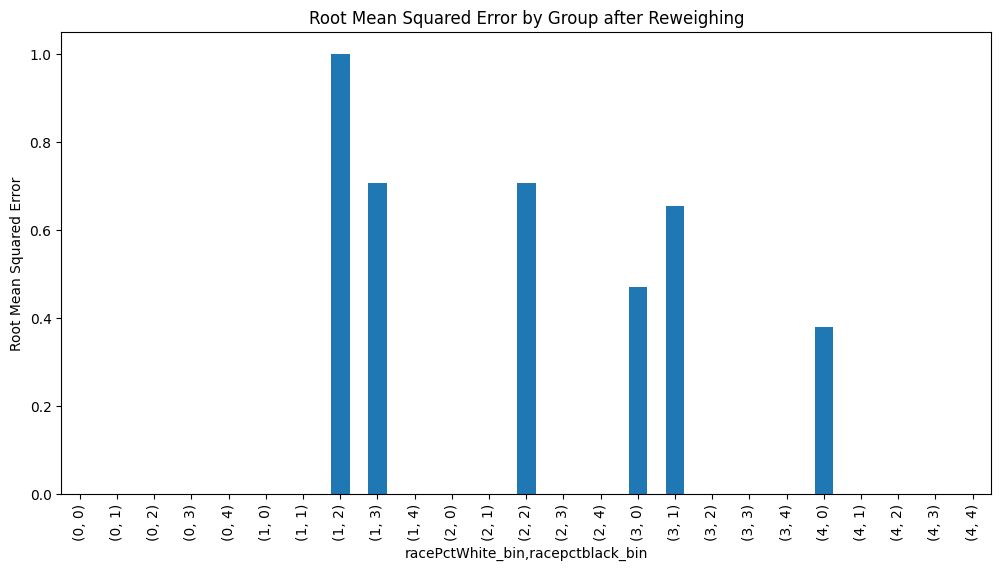

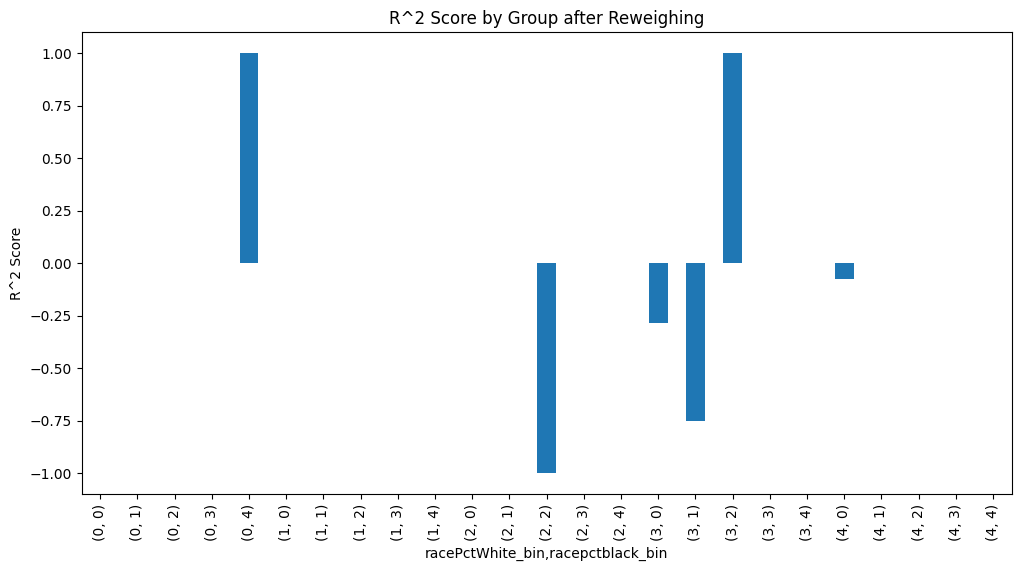

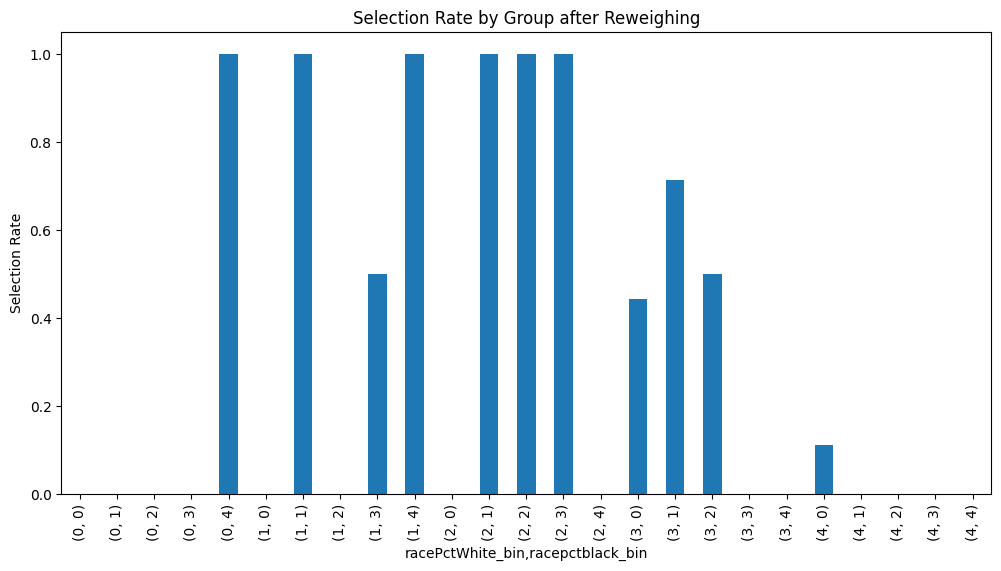

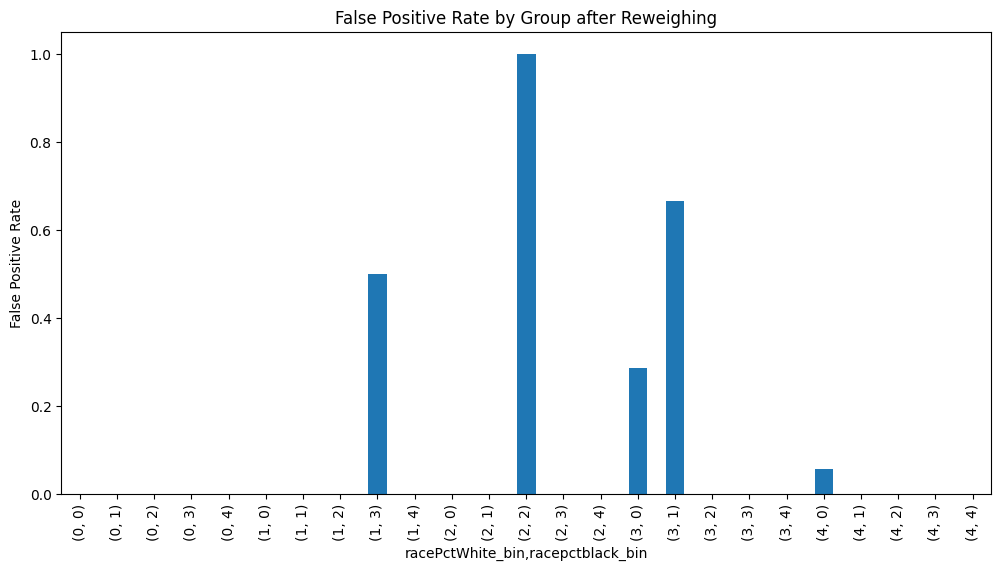

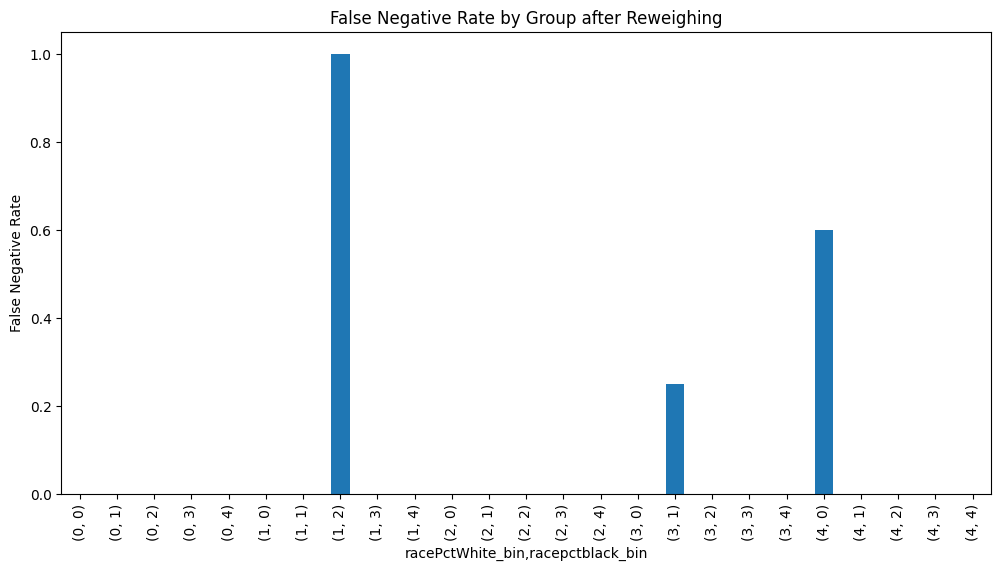

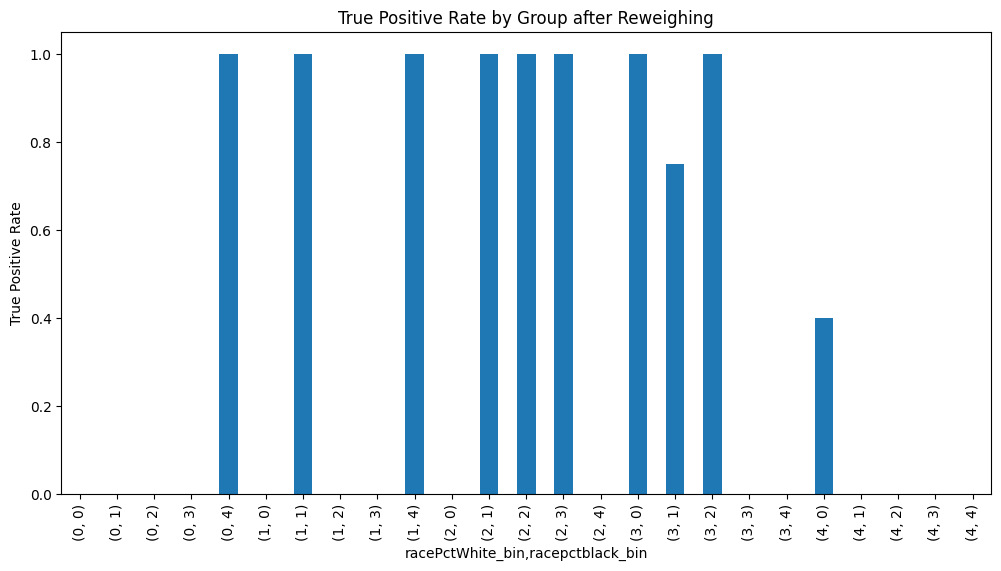

In [8]:
# Extract metrics for visualization
metrics_by_group_rw = metrics_rw.by_group.apply(pd.Series)
mae_rw = metrics_by_group_rw['mean_absolute_error']
rmse_rw = metrics_by_group_rw['root_mean_squared_error']
r2_rw = metrics_by_group_rw['r2_score']
selection_rate_rw = metrics_by_group_rw['selection_rate']
fpr_rw = metrics_by_group_rw['false_positive_rate']
fnr_rw = metrics_by_group_rw['false_negative_rate']
tpr_rw = metrics_by_group_rw['true_positive_rate']

# Plot Mean Absolute Error by Group after Reweighing
mae_rw.plot(kind='bar', figsize=(12, 6), title='Mean Absolute Error by Group after Reweighing')
plt.ylabel('Mean Absolute Error')
plt.show()

# Plot Root Mean Squared Error by Group after Reweighing
rmse_rw.plot(kind='bar', figsize=(12, 6), title='Root Mean Squared Error by Group after Reweighing')
plt.ylabel('Root Mean Squared Error')
plt.show()

# Plot R^2 Score by Group after Reweighing
r2_rw.plot(kind='bar', figsize=(12, 6), title='R^2 Score by Group after Reweighing')
plt.ylabel('R^2 Score')
plt.show()

# Plot Selection Rate by Group after Reweighing
selection_rate_rw.plot(kind='bar', figsize=(12, 6), title='Selection Rate by Group after Reweighing')
plt.ylabel('Selection Rate')
plt.show()

# Plot False Positive Rate by Group after Reweighing
fpr_rw.plot(kind='bar', figsize=(12, 6), title='False Positive Rate by Group after Reweighing')
plt.ylabel('False Positive Rate')
plt.show()

# Plot False Negative Rate by Group after Reweighing
fnr_rw.plot(kind='bar', figsize=(12, 6), title='False Negative Rate by Group after Reweighing')
plt.ylabel('False Negative Rate')
plt.show()

# Plot True Positive Rate by Group after Reweighing
tpr_rw.plot(kind='bar', figsize=(12, 6), title='True Positive Rate by Group after Reweighing')
plt.ylabel('True Positive Rate')
plt.show()


C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  s

Overall Metrics after Adversarial Debiasing:
{'mean_absolute_error': 0.27472527472527475, 'root_mean_squared_error': 0.5241424183609592, 'r2_score': -0.37878787878787845, 'selection_rate': 0.0, 'false_positive_rate': 0.0, 'false_negative_rate': 1.0, 'true_positive_rate': 0.0}

Metrics by Sensitive Feature Groups after Adversarial Debiasing:
racePctWhite_bin  racepctblack_bin
0                 0                                                                 NaN
                  1                                                                 NaN
                  2                                                                 NaN
                  3                                                                 NaN
                  4                   {'mean_absolute_error': 1.0, 'root_mean_square...
1                 0                                                                 NaN
                  1                   {'mean_absolute_error': 1.0, 'root_mean_square...
      

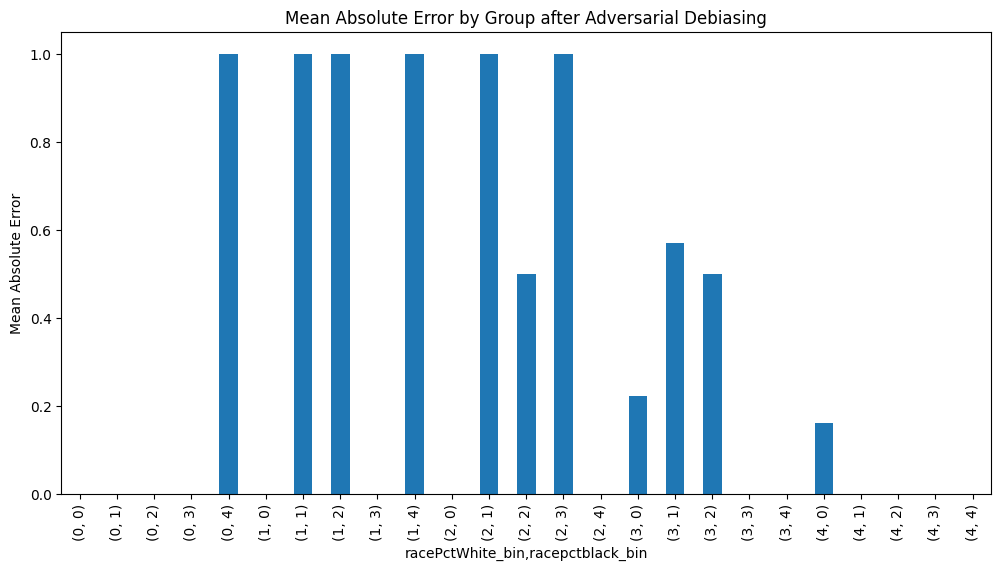

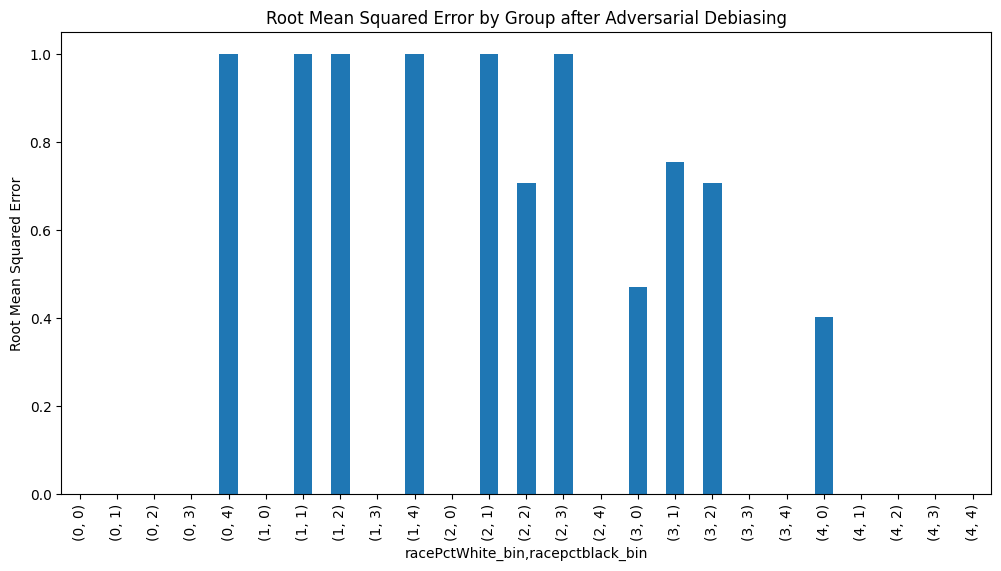

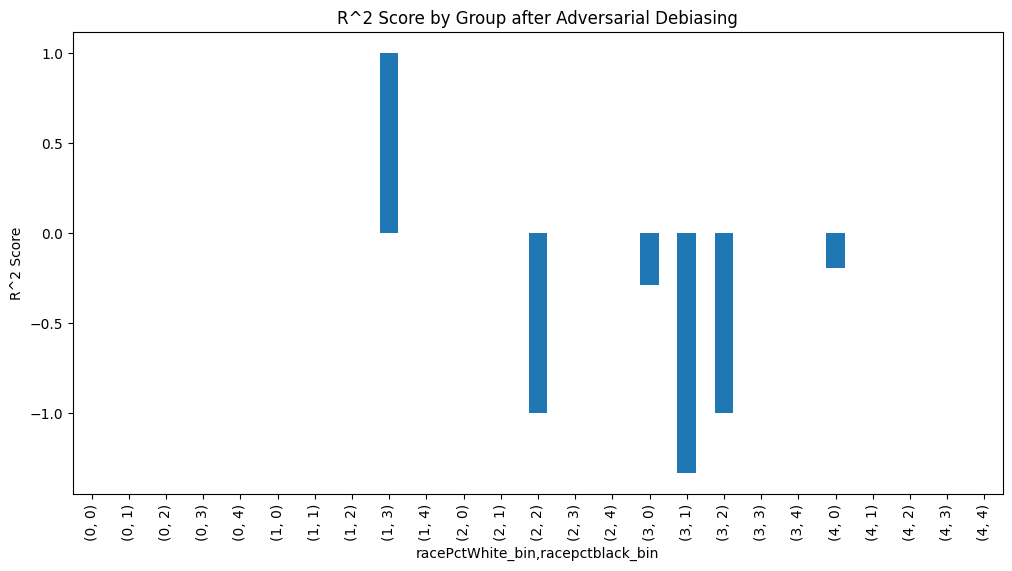

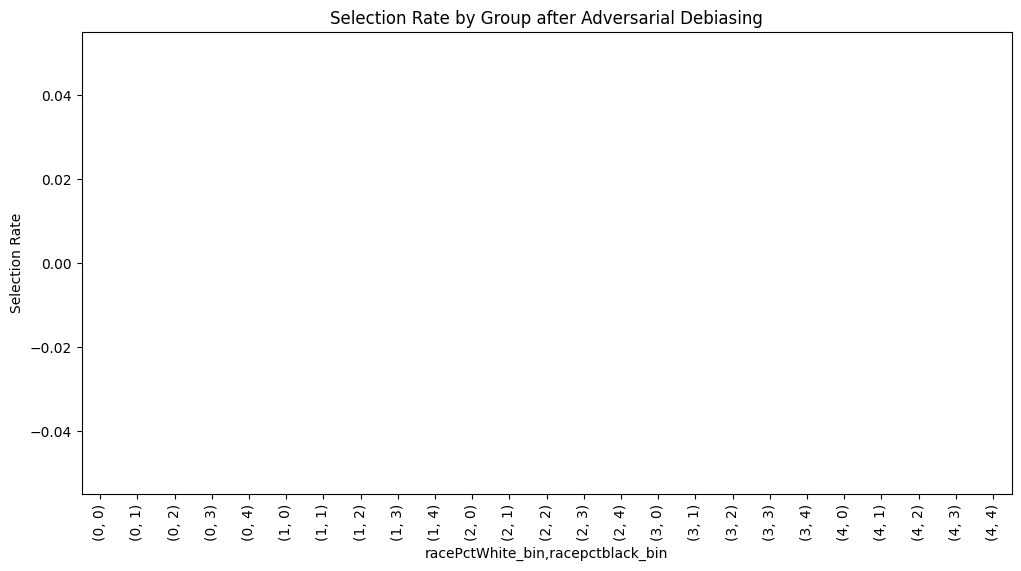

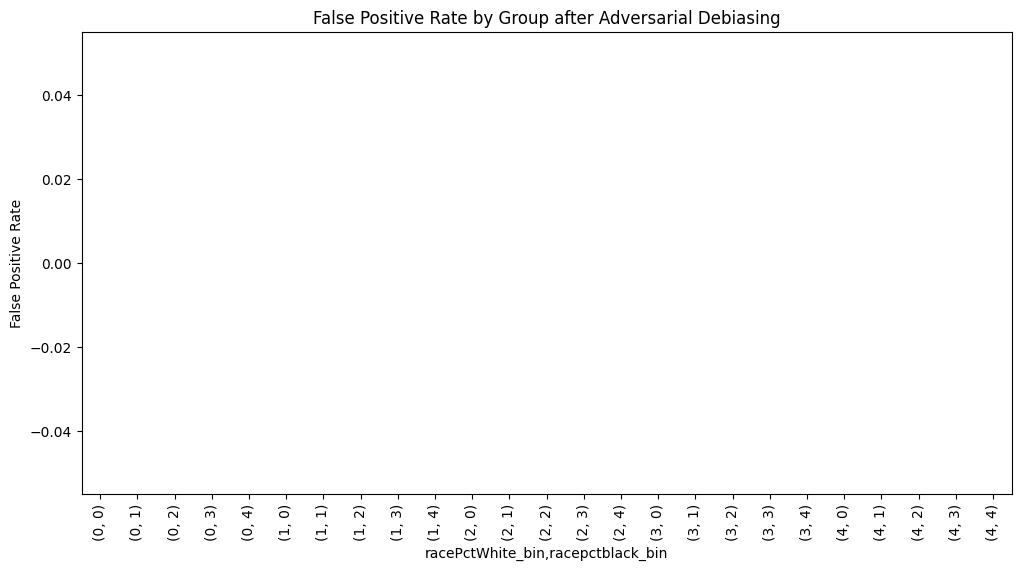

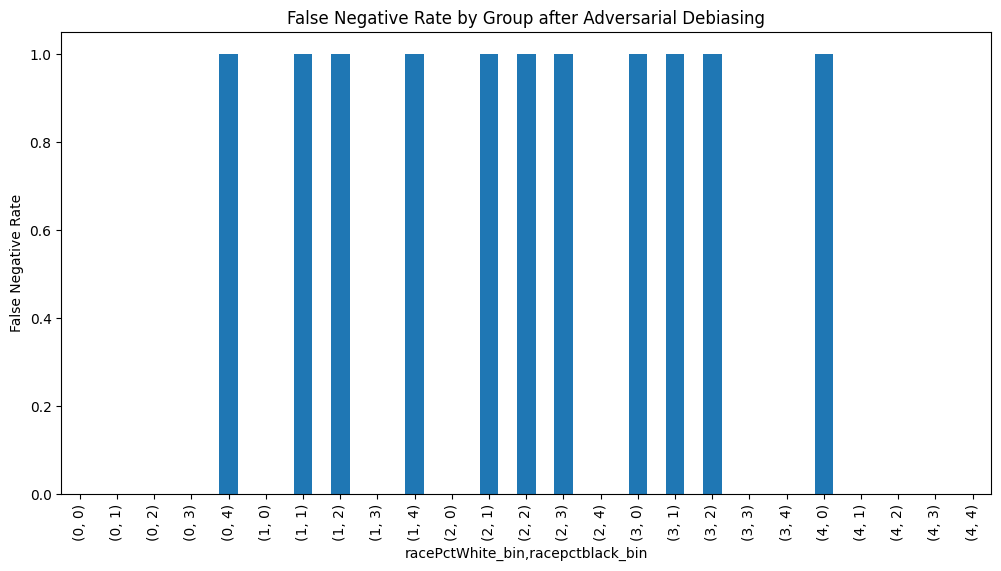

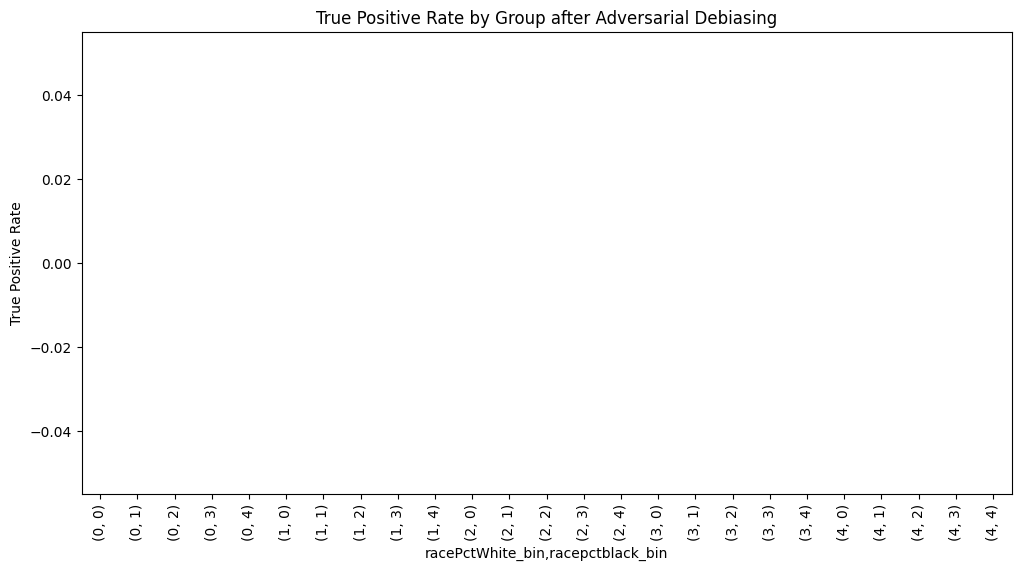

In [9]:
# Perform adversarial debiasing using Exponentiated Gradient Reduction
mitigator = ExponentiatedGradient(estimator=RandomForestClassifier(random_state=42), 
                                  constraints=DemographicParity())

mitigator.fit(X_train, y_train, sensitive_features=data.loc[X_train.index, ['racePctWhite_bin', 'racepctblack_bin']])

y_pred_ad = mitigator.predict(X_test)

# Compute metrics for different groups
metrics_ad = MetricFrame(
    metrics=compute_metrics,
    y_true=y_test,
    y_pred=y_pred_ad,
    sensitive_features=data.loc[X_test.index, ['racePctWhite_bin', 'racepctblack_bin']]
)

# Print the overall metrics
print("Overall Metrics after Adversarial Debiasing:")
print(metrics_ad.overall)

# Print metrics by sensitive feature groups
print("\nMetrics by Sensitive Feature Groups after Adversarial Debiasing:")
print(metrics_ad.by_group)

# Extract metrics for visualization
metrics_by_group_ad = metrics_ad.by_group.apply(pd.Series)
mae_ad = metrics_by_group_ad['mean_absolute_error']
rmse_ad = metrics_by_group_ad['root_mean_squared_error']
r2_ad = metrics_by_group_ad['r2_score']
selection_rate_ad = metrics_by_group_ad['selection_rate']
fpr_ad = metrics_by_group_ad['false_positive_rate']
fnr_ad = metrics_by_group_ad['false_negative_rate']
tpr_ad = metrics_by_group_ad['true_positive_rate']

# Plot Mean Absolute Error by Group after Adversarial Debiasing
mae_ad.plot(kind='bar', figsize=(12, 6), title='Mean Absolute Error by Group after Adversarial Debiasing')
plt.ylabel('Mean Absolute Error')
plt.show()

# Plot Root Mean Squared Error by Group after Adversarial Debiasing
rmse_ad.plot(kind='bar', figsize=(12, 6), title='Root Mean Squared Error by Group after Adversarial Debiasing')
plt.ylabel('Root Mean Squared Error')
plt.show()

# Plot R^2 Score by Group after Adversarial Debiasing
r2_ad.plot(kind='bar', figsize=(12, 6), title='R^2 Score by Group after Adversarial Debiasing')
plt.ylabel('R^2 Score')
plt.show()

# Plot Selection Rate by Group after Adversarial Debiasing
selection_rate_ad.plot(kind='bar', figsize=(12, 6), title='Selection Rate by Group after Adversarial Debiasing')
plt.ylabel('Selection Rate')
plt.show()

# Plot False Positive Rate by Group after Adversarial Debiasing
fpr_ad.plot(kind='bar', figsize=(12, 6), title='False Positive Rate by Group after Adversarial Debiasing')
plt.ylabel('False Positive Rate')
plt.show()

# Plot False Negative Rate by Group after Adversarial Debiasing
fnr_ad.plot(kind='bar', figsize=(12, 6), title='False Negative Rate by Group after Adversarial Debiasing')
plt.ylabel('False Negative Rate')
plt.show()

# Plot True Positive Rate by Group after Adversarial Debiasing
tpr_ad.plot(kind='bar', figsize=(12, 6), title='True Positive Rate by Group after Adversarial Debiasing')
plt.ylabel('True Positive Rate')
plt.show()


C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fairlearn\postprocessing\_threshold_optimizer.py:288: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(
C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' 

Overall Metrics after Post-processing:
{'mean_absolute_error': 0.1978021978021978, 'root_mean_squared_error': 0.4447495899966607, 'r2_score': 0.007272727272727431, 'selection_rate': 0.31868131868131866, 'false_positive_rate': 0.16666666666666666, 'false_negative_rate': 0.28, 'true_positive_rate': 0.72}

Metrics by Sensitive Feature Groups after Post-processing:
racePctWhite_bin
0    {'mean_absolute_error': 0.0, 'root_mean_square...
1    {'mean_absolute_error': 0.2, 'root_mean_square...
2    {'mean_absolute_error': 0.25, 'root_mean_squar...
3    {'mean_absolute_error': 0.3333333333333333, 'r...
4    {'mean_absolute_error': 0.16129032258064516, '...
Name: compute_metrics, dtype: object


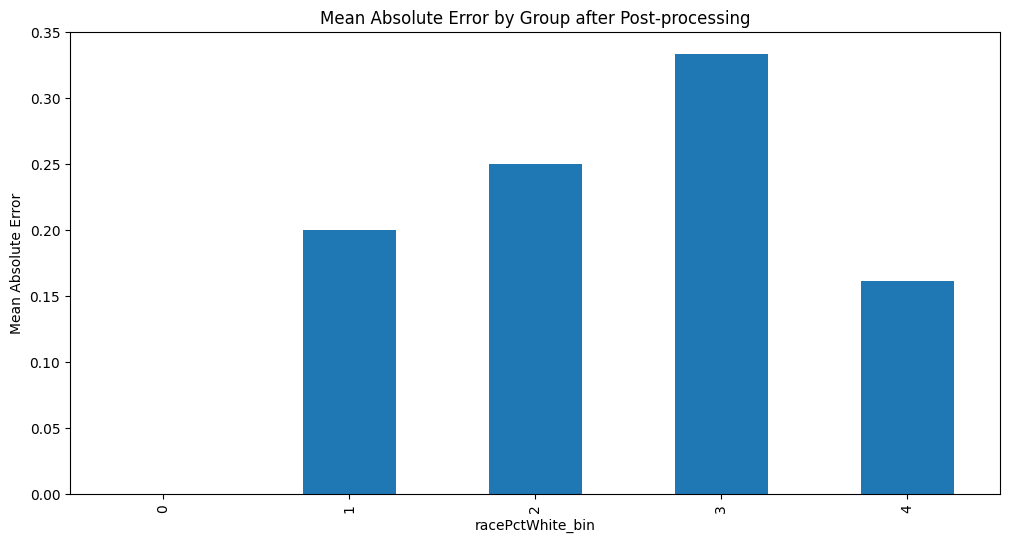

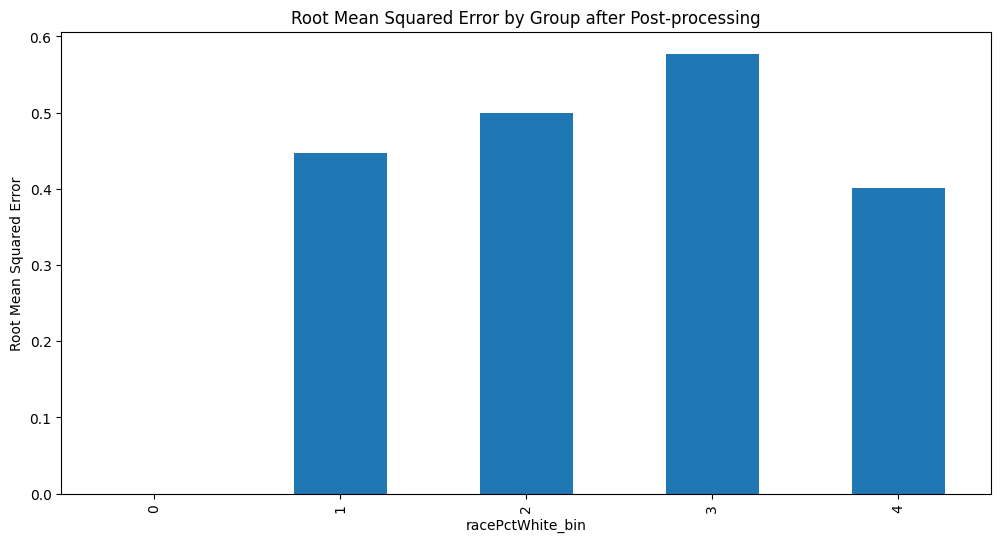

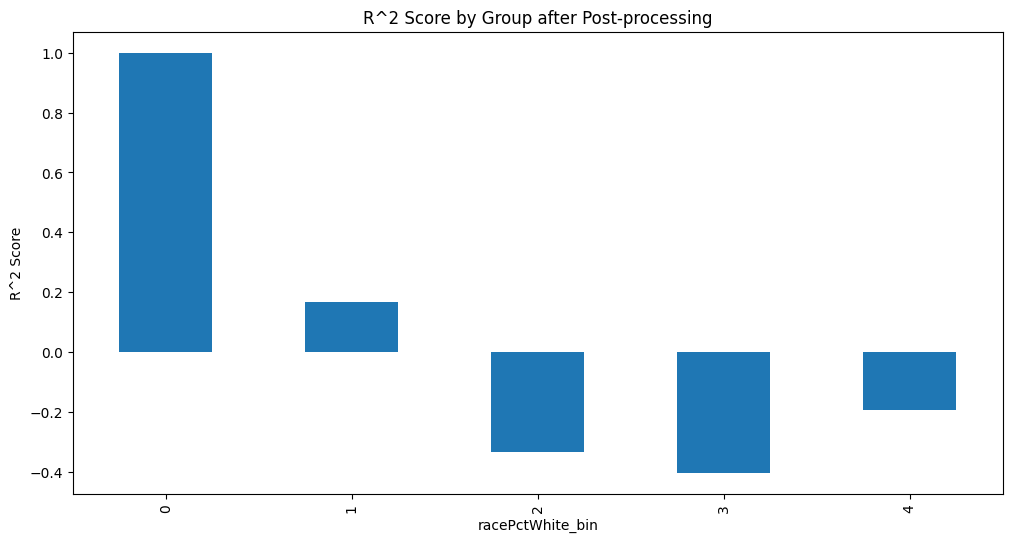

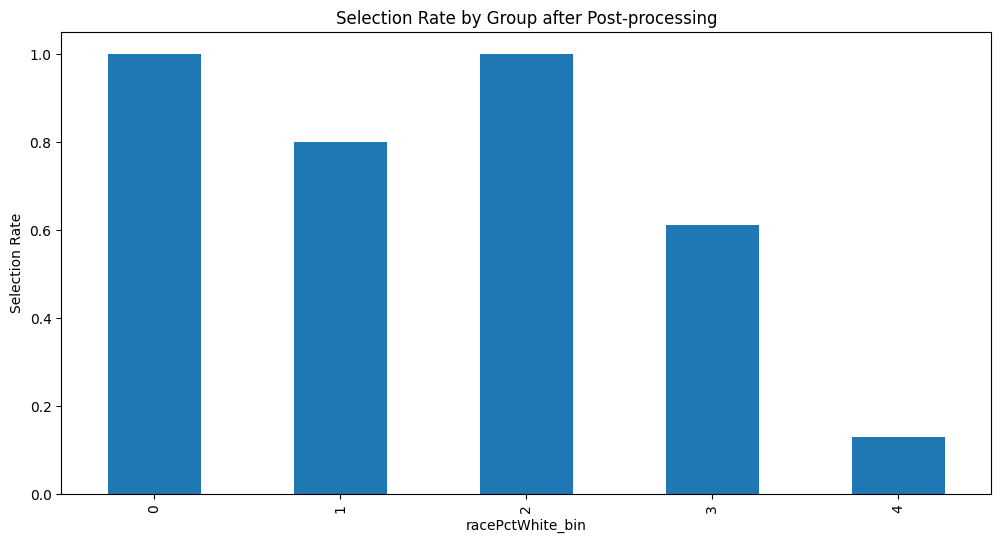

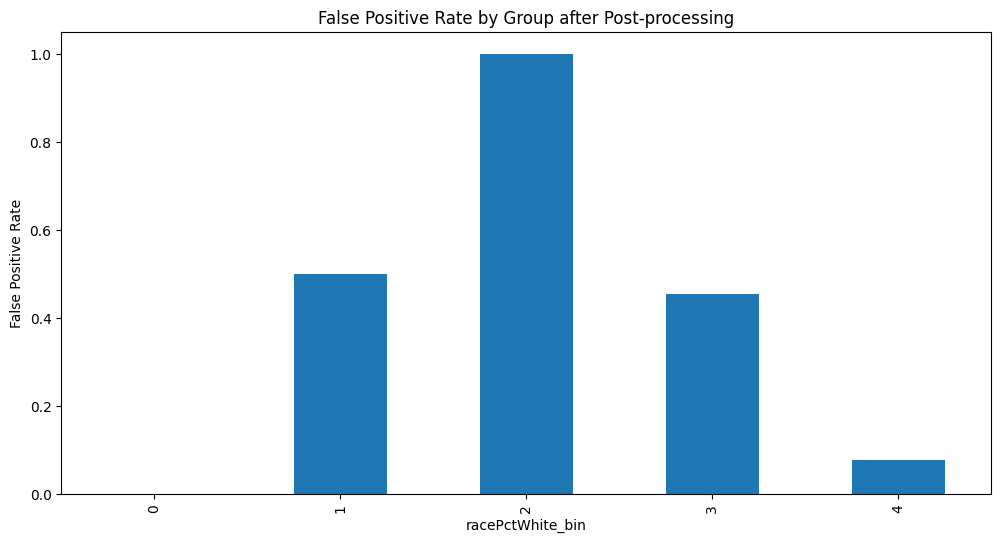

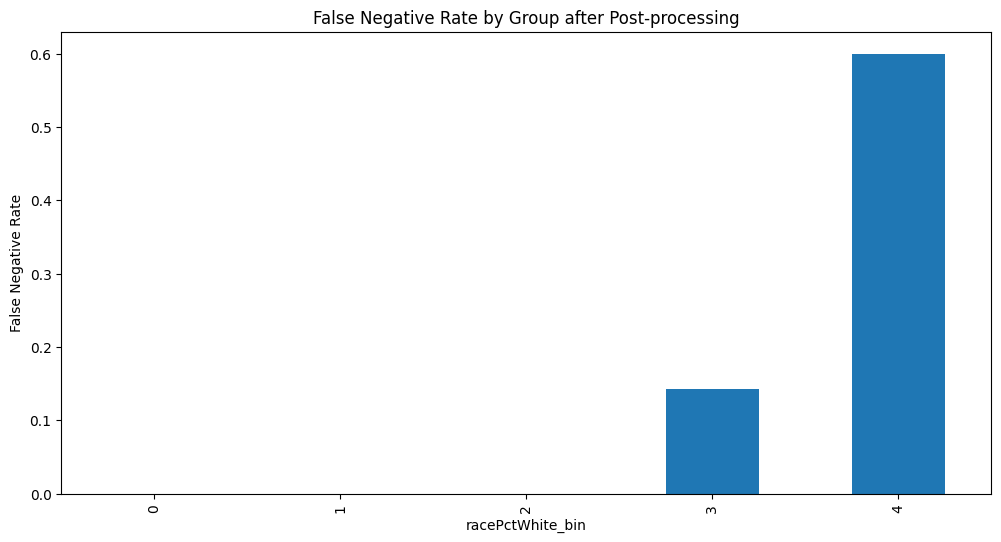

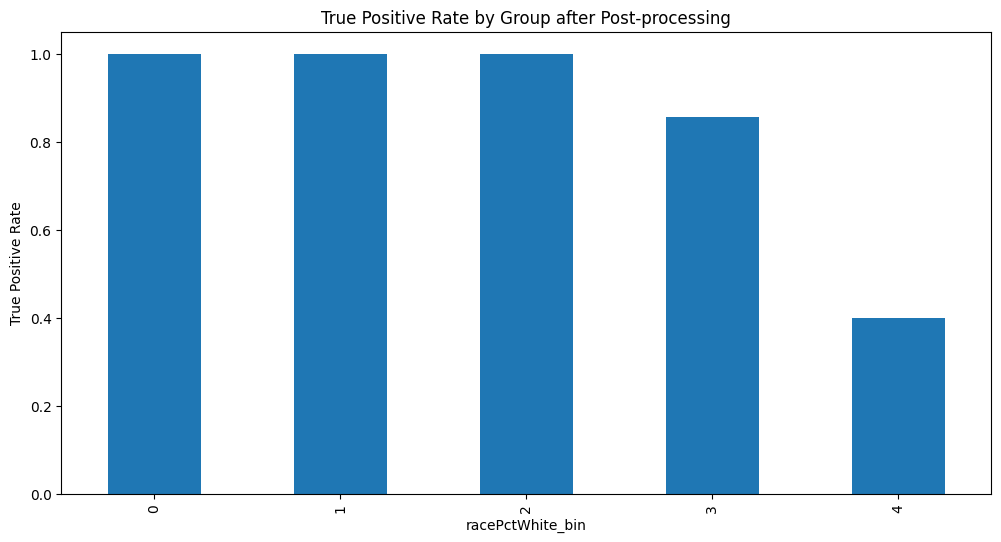

In [10]:
# Perform post-processing using ThresholdOptimizer
postprocess_est = ThresholdOptimizer(estimator=rf_model, 
                                     constraints="equalized_odds", 
                                     prefit=True)

postprocess_est.fit(X_train, y_train, sensitive_features=data.loc[X_train.index, 'racePctWhite_bin'])

y_pred_pp = postprocess_est.predict(X_test, sensitive_features=data.loc[X_test.index, 'racePctWhite_bin'])

# Compute metrics for different groups
metrics_pp = MetricFrame(
    metrics=compute_metrics,
    y_true=y_test,
    y_pred=y_pred_pp,
    sensitive_features=data.loc[X_test.index, 'racePctWhite_bin']
)

# Print the overall metrics
print("Overall Metrics after Post-processing:")
print(metrics_pp.overall)

# Print metrics by sensitive feature groups
print("\nMetrics by Sensitive Feature Groups after Post-processing:")
print(metrics_pp.by_group)

# Extract metrics for visualization
metrics_by_group_pp = metrics_pp.by_group.apply(pd.Series)
mae_pp = metrics_by_group_pp['mean_absolute_error']
rmse_pp = metrics_by_group_pp['root_mean_squared_error']
r2_pp = metrics_by_group_pp['r2_score']
selection_rate_pp = metrics_by_group_pp['selection_rate']
fpr_pp = metrics_by_group_pp['false_positive_rate']
fnr_pp = metrics_by_group_pp['false_negative_rate']
tpr_pp = metrics_by_group_pp['true_positive_rate']

# Plot Mean Absolute Error by Group after Post-processing
mae_pp.plot(kind='bar', figsize=(12, 6), title='Mean Absolute Error by Group after Post-processing')
plt.ylabel('Mean Absolute Error')
plt.show()

# Plot Root Mean Squared Error by Group after Post-processing
rmse_pp.plot(kind='bar', figsize=(12, 6), title='Root Mean Squared Error by Group after Post-processing')
plt.ylabel('Root Mean Squared Error')
plt.show()

# Plot R^2 Score by Group after Post-processing
r2_pp.plot(kind='bar', figsize=(12, 6), title='R^2 Score by Group after Post-processing')
plt.ylabel('R^2 Score')
plt.show()

# Plot Selection Rate by Group after Post-processing
selection_rate_pp.plot(kind='bar', figsize=(12, 6), title='Selection Rate by Group after Post-processing')
plt.ylabel('Selection Rate')
plt.show()

# Plot False Positive Rate by Group after Post-processing
fpr_pp.plot(kind='bar', figsize=(12, 6), title='False Positive Rate by Group after Post-processing')
plt.ylabel('False Positive Rate')
plt.show()

# Plot False Negative Rate by Group after Post-processing
fnr_pp.plot(kind='bar', figsize=(12, 6), title='False Negative Rate by Group after Post-processing')
plt.ylabel('False Negative Rate')
plt.show()

# Plot True Positive Rate by Group after Post-processing
tpr_pp.plot(kind='bar', figsize=(12, 6), title='True Positive Rate by Group after Post-processing')
plt.ylabel('True Positive Rate')
plt.show()


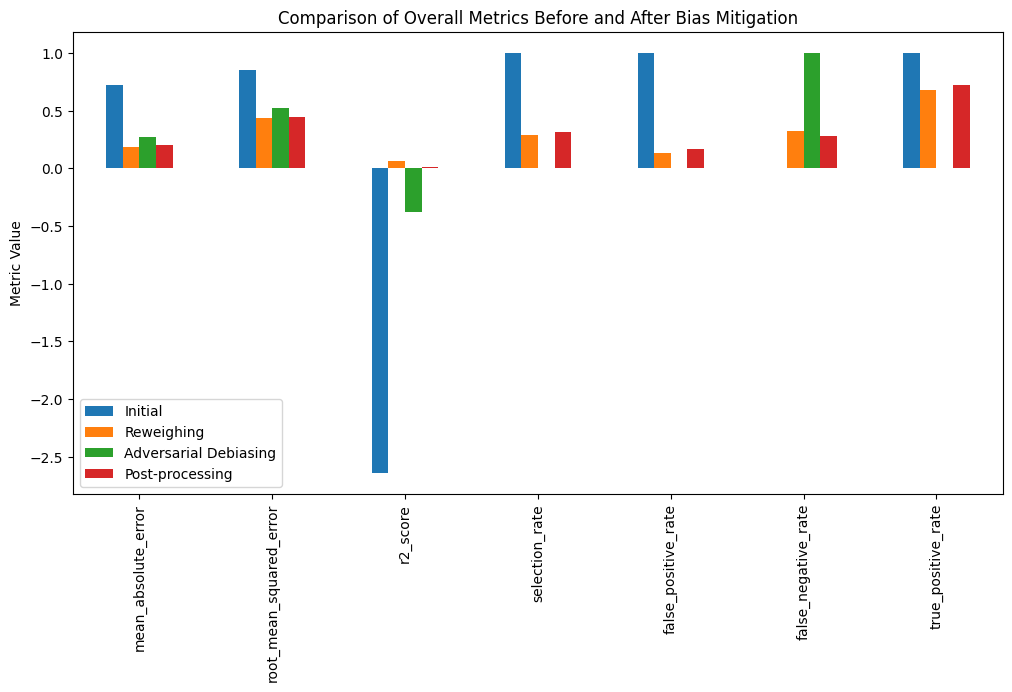

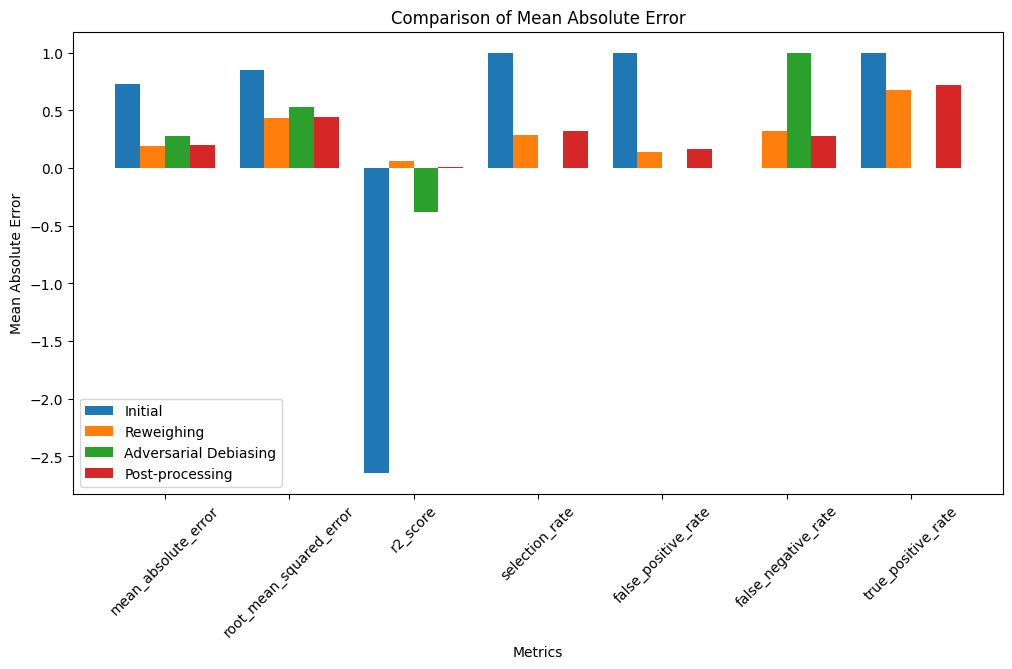

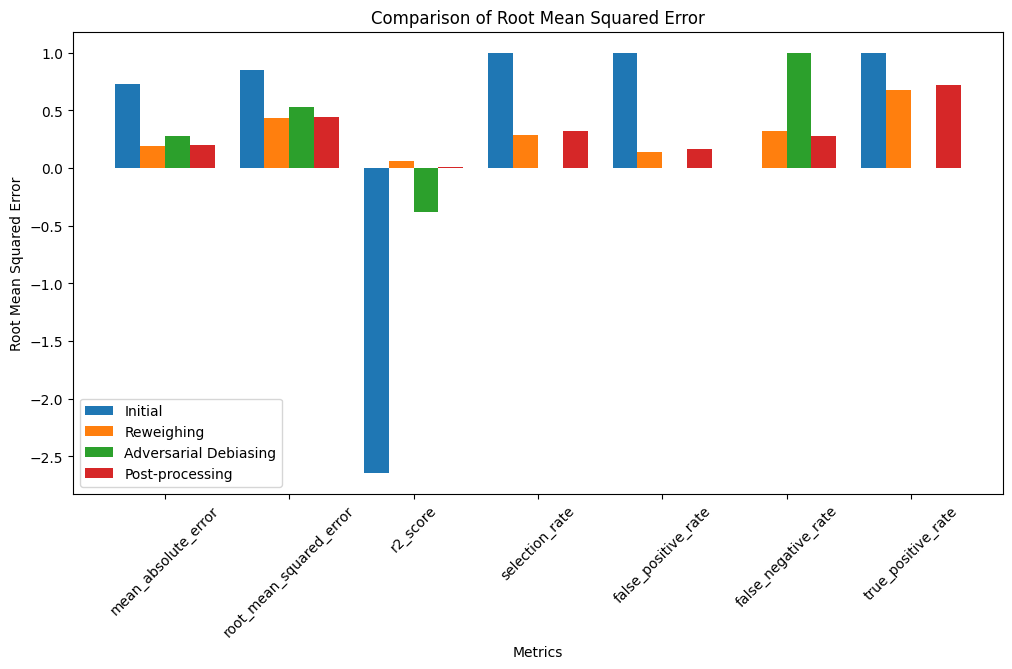

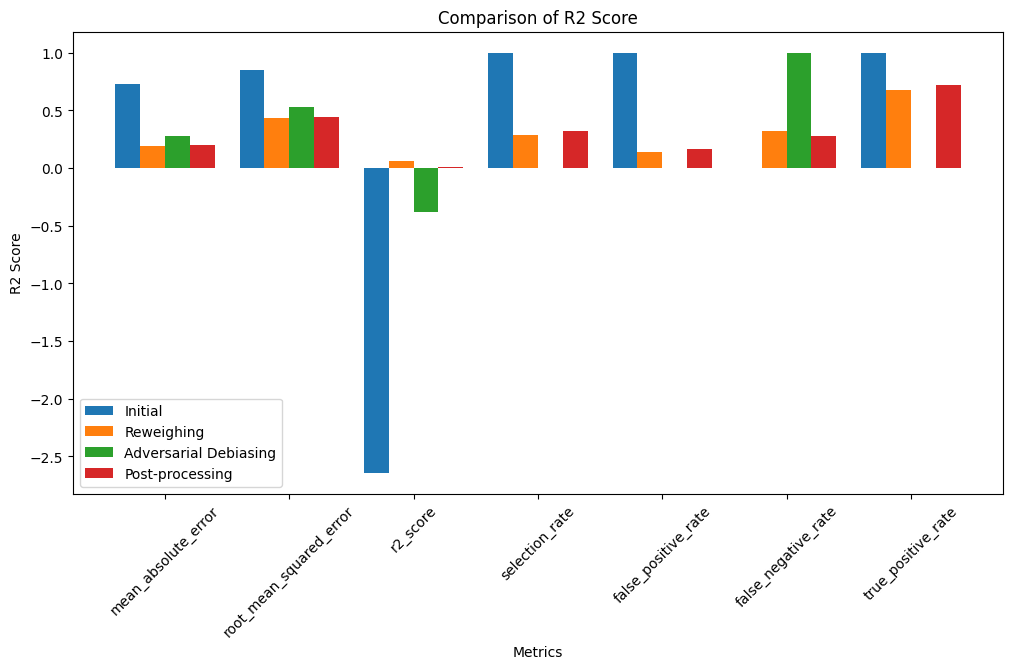

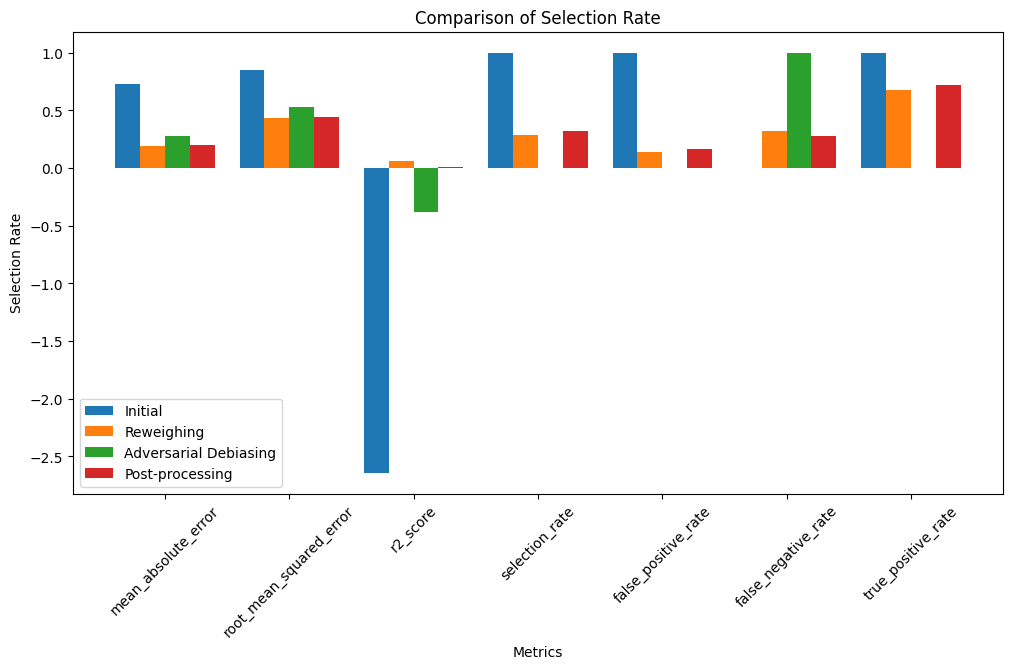

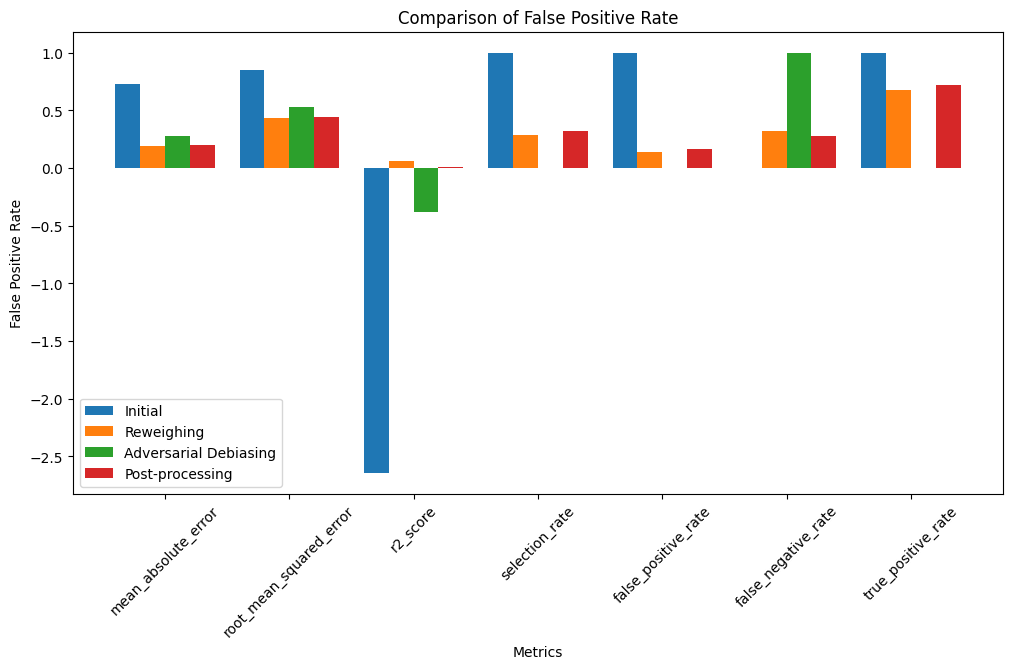

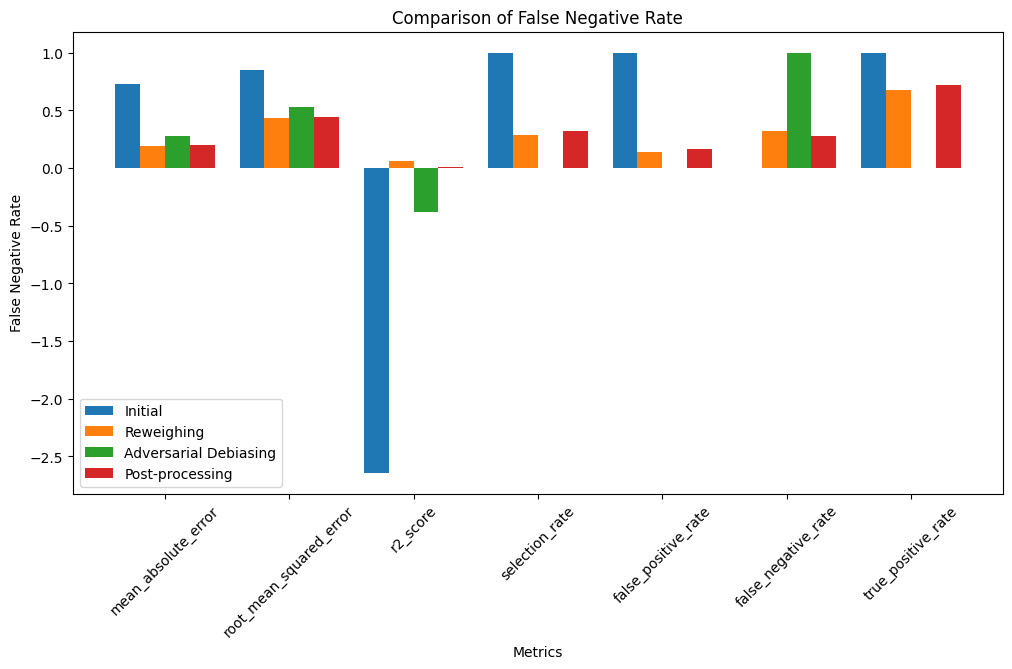

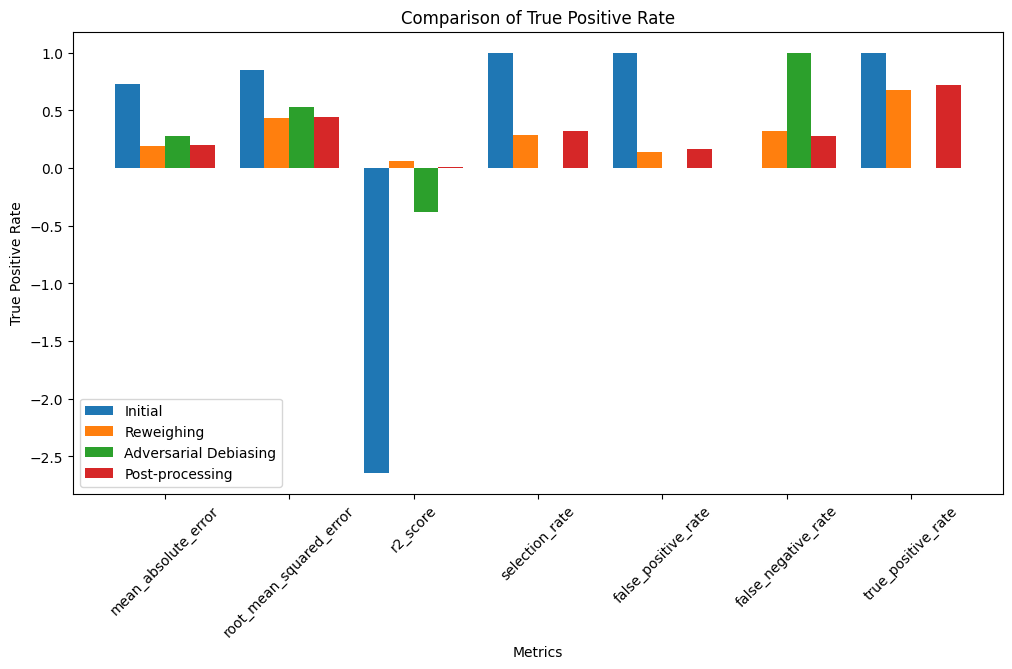

In [11]:
# Comparison of results before and after bias mitigation

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Initial': metrics.overall,
    'Reweighing': metrics_rw.overall,
    'Adversarial Debiasing': metrics_ad.overall,
    'Post-processing': metrics_pp.overall
})

# Plot comparison
comparison_df.plot(kind='bar', figsize=(12, 6), title='Comparison of Overall Metrics Before and After Bias Mitigation')
plt.ylabel('Metric Value')
plt.show()

# Function to plot comparison of metrics for different mitigation steps
def plot_metric_comparison(metrics_initial, metrics_rw, metrics_ad, metrics_pp, metric_name, ylabel, title):
    labels = metrics_initial.keys()

    x = np.arange(len(labels))
    width = 0.2

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width * 1.5, list(metrics_initial.values()), width, label='Initial')
    rects2 = ax.bar(x - width / 2, list(metrics_rw.values()), width, label='Reweighing')
    rects3 = ax.bar(x + width / 2, list(metrics_ad.values()), width, label='Adversarial Debiasing')
    rects4 = ax.bar(x + width * 1.5, list(metrics_pp.values()), width, label='Post-processing')

    ax.set_xlabel('Metrics')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend()

    plt.show()

# Extracting overall metrics
overall_metrics_initial = metrics.overall
overall_metrics_rw = metrics_rw.overall
overall_metrics_ad = metrics_ad.overall
overall_metrics_pp = metrics_pp.overall

# Plot overall metrics comparison
def plot_overall_metric_comparison():
    metric_names = ['mean_absolute_error', 'root_mean_squared_error', 'r2_score', 'selection_rate', 
                    'false_positive_rate', 'false_negative_rate', 'true_positive_rate']
    for metric in metric_names:
        plot_metric_comparison(
            overall_metrics_initial, overall_metrics_rw, overall_metrics_ad, overall_metrics_pp, 
            metric, metric.replace('_', ' ').title(), f'Comparison of {metric.replace("_", " ").title()}'
        )

# Plot overall metric comparison
plot_overall_metric_comparison()

# Plot metrics by group comparison
def plot_metrics_by_group_comparison(metrics_by_group_initial, metrics_by_group_rw, metrics_by_group_ad, metrics_by_group_pp):
    metric_names = ['mean_absolute_error', 'root_mean_squared_error', 'r2_score', 'selection_rate', 
                    'false_positive_rate', 'false_negative_rate', 'true_positive_rate']
    for metric in metric_names:
        plot_metric_comparison(
            metrics_by_group_initial[metric], metrics_by_group_rw[metric], metrics_by_group_ad[metric], metrics_by_group_pp[metric], 
            metric, metric.replace('_', ' ').title(), f'Comparison of {metric.replace("_", " ").title()} by Group'
        )


In [12]:
# Function to ensure all required keys are present in the metrics dictionary
def ensure_all_keys_present(metrics_dict, required_keys):
    for group in metrics_dict:
        for key in required_keys:
            if key not in metrics_dict[group]:
                metrics_dict[group][key] = 0.0
    return metrics_dict

# Extracting metrics by group
metrics_by_group_initial = metrics.by_group.apply(pd.Series).to_dict()
metrics_by_group_rw = metrics_rw.by_group.apply(pd.Series).to_dict()
metrics_by_group_ad = metrics_ad.by_group.apply(pd.Series).to_dict()
metrics_by_group_pp = metrics_pp.by_group.apply(pd.Series).to_dict()

# Define the common keys
common_keys = ['mean_absolute_error', 'root_mean_squared_error', 'r2_score', 'selection_rate', 
               'false_positive_rate', 'false_negative_rate', 'true_positive_rate']

# Ensure all required keys are present in each metrics dictionary
metrics_by_group_initial = ensure_all_keys_present(metrics_by_group_initial, common_keys)
metrics_by_group_rw = ensure_all_keys_present(metrics_by_group_rw, common_keys)
metrics_by_group_ad = ensure_all_keys_present(metrics_by_group_ad, common_keys)
metrics_by_group_pp = ensure_all_keys_present(metrics_by_group_pp, common_keys)

# Get the intersection of groups across all metric dictionaries
common_groups = set(metrics_by_group_initial.keys()) & set(metrics_by_group_rw.keys()) & set(metrics_by_group_ad.keys()) & set(metrics_by_group_pp.keys())

# Function to align metrics correctly based on common groups
def align_metrics_correctly(metrics_dict, common_groups, common_keys):
    aligned_metrics = {key: [] for key in common_keys}
    for group in common_groups:
        for key in common_keys:
            aligned_metrics[key].append(metrics_dict[group][key])
    return aligned_metrics

aligned_initial = align_metrics_correctly(metrics_by_group_initial, common_groups, common_keys)
aligned_rw = align_metrics_correctly(metrics_by_group_rw, common_groups, common_keys)
aligned_ad = align_metrics_correctly(metrics_by_group_ad, common_groups, common_keys)
aligned_pp = align_metrics_correctly(metrics_by_group_pp, common_groups, common_keys)

# Convert aligned metrics to lists
aligned_initial = {k: v for k, v in aligned_initial.items()}
aligned_rw = {k: v for k, v in aligned_rw.items()}
aligned_ad = {k: v for k, v in aligned_ad.items()}
aligned_pp = {k: v for k, v in aligned_pp.items()}


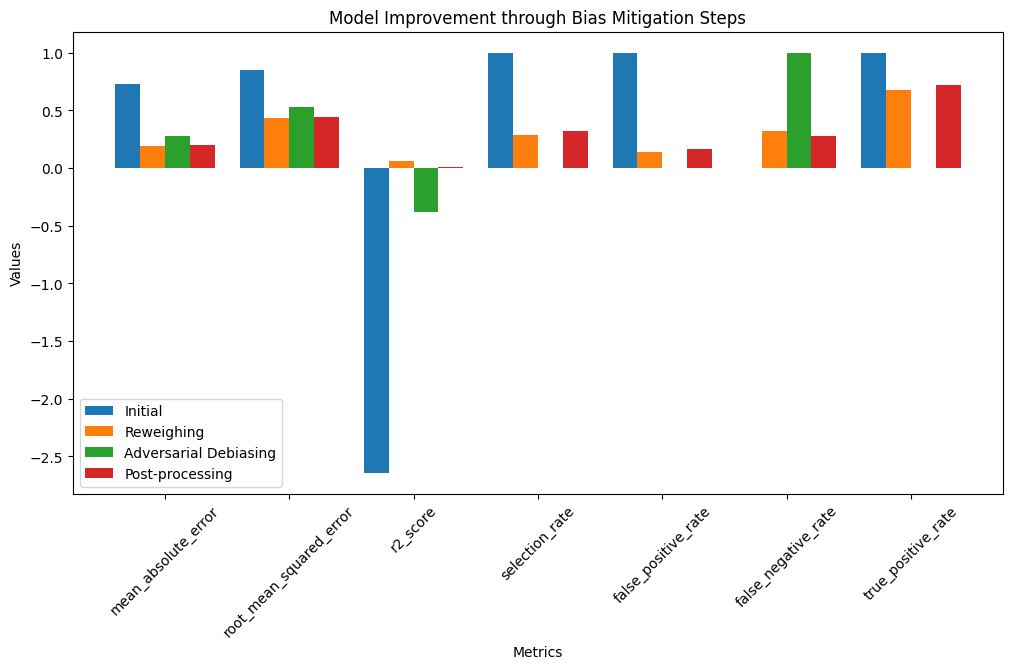

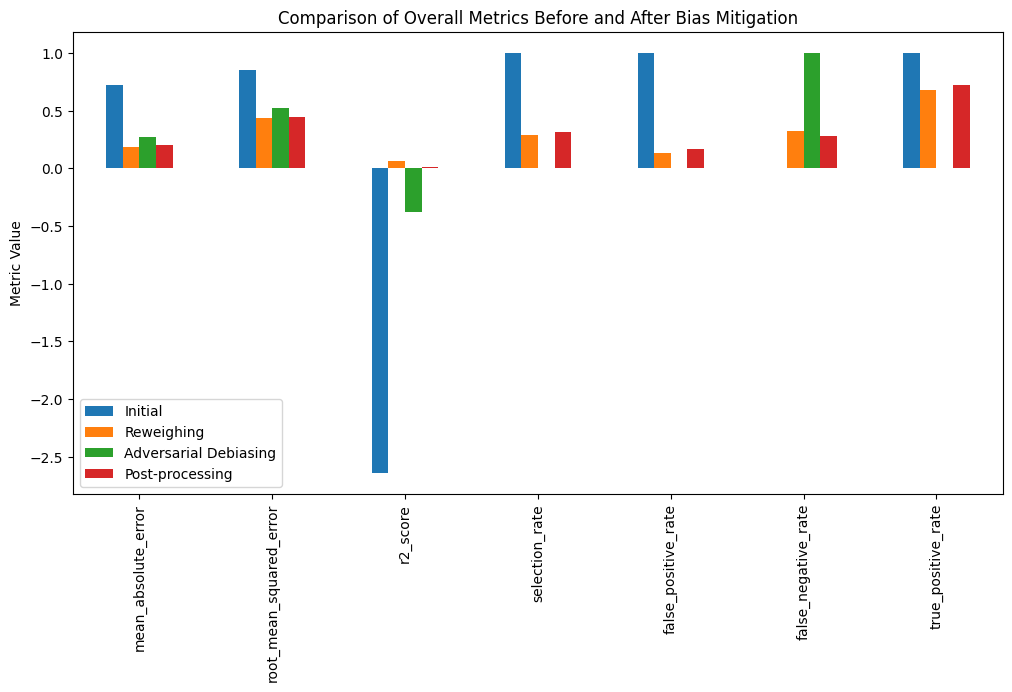

Done


In [13]:
# Plot metrics by group comparison
def plot_metrics_by_group_comparison(metrics_by_group_initial, metrics_by_group_rw, metrics_by_group_ad, metrics_by_group_pp):
    metric_names = ['mean_absolute_error', 'root_mean_squared_error', 'r2_score', 'selection_rate', 
                    'false_positive_rate', 'false_negative_rate', 'true_positive_rate']
    
    for metric in metric_names:
        plot_metric_comparison(
            metrics_by_group_initial[metric], metrics_by_group_rw[metric], metrics_by_group_ad[metric], metrics_by_group_pp[metric], 
            metric, metric.replace('_', ' ').title(), f'Comparison of {metric.replace("_", " ").title()} by Group'
        )

def plot_metric_comparison(metrics_initial, metrics_rw, metrics_ad, metrics_pp, metric_name, ylabel, title):
    labels = range(len(metrics_initial))  # Assume the same number of groups for each metric

    x = np.arange(len(labels))
    width = 0.2

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width * 1.5, metrics_initial, width, label='Initial')
    rects2 = ax.bar(x - width / 2, metrics_rw, width, label='Reweighing')
    rects3 = ax.bar(x + width / 2, metrics_ad, width, label='Adversarial Debiasing')
    rects4 = ax.bar(x + width * 1.5, metrics_pp, width, label='Post-processing')

    ax.set_xlabel('Groups')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend()

    plt.show()

# Plot metrics by group comparison
# plot_metrics_by_group_comparison(aligned_initial, aligned_rw, aligned_ad, aligned_pp)

# Summary plot to show model improvement
def plot_model_improvement(summary_metrics):
    fig, ax = plt.subplots(figsize=(12, 6))
    labels = summary_metrics.index
    x = np.arange(len(labels))
    width = 0.2

    rects1 = ax.bar(x - width * 1.5, summary_metrics['Initial'], width, label='Initial')
    rects2 = ax.bar(x - width / 2, summary_metrics['Reweighing'], width, label='Reweighing')
    rects3 = ax.bar(x + width / 2, summary_metrics['Adversarial Debiasing'], width, label='Adversarial Debiasing')
    rects4 = ax.bar(x + width * 1.5, summary_metrics['Post-processing'], width, label='Post-processing')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title('Model Improvement through Bias Mitigation Steps')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend()

    plt.show()

# Creating a DataFrame to summarize overall metrics for final improvement plot
summary_metrics = pd.DataFrame({
    'Initial': list(overall_metrics_initial.values()),
    'Reweighing': list(overall_metrics_rw.values()),
    'Adversarial Debiasing': list(overall_metrics_ad.values()),
    'Post-processing': list(overall_metrics_pp.values())
}, index=overall_metrics_initial.keys())

# Plot model improvement summary
plot_model_improvement(summary_metrics)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Initial': overall_metrics_initial,
    'Reweighing': overall_metrics_rw,
    'Adversarial Debiasing': overall_metrics_ad,
    'Post-processing': overall_metrics_pp
})

comparison_df.plot(kind='bar', figsize=(12, 6), title='Comparison of Overall Metrics Before and After Bias Mitigation')
plt.ylabel('Metric Value')
plt.show()

print("Done")


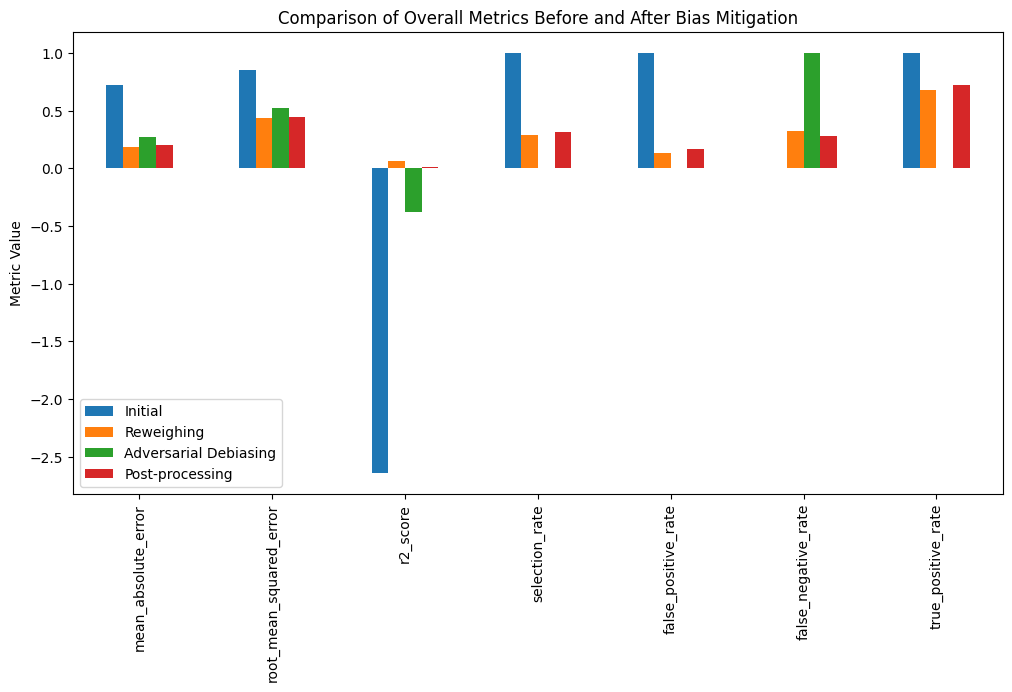

Second Done


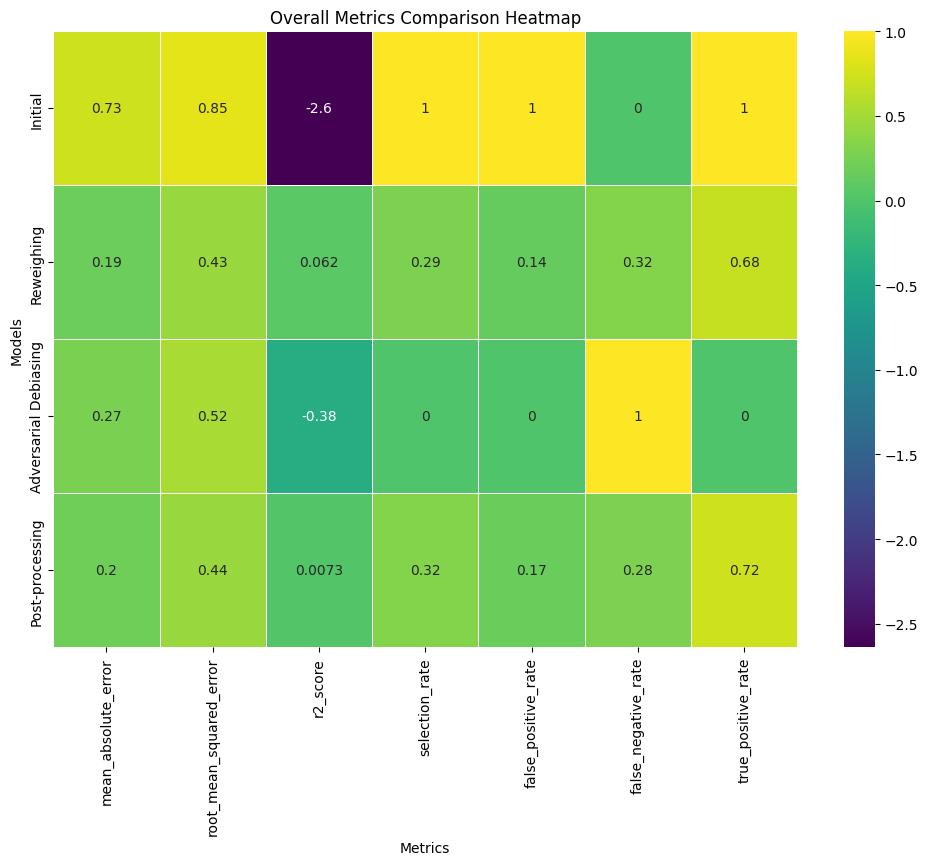

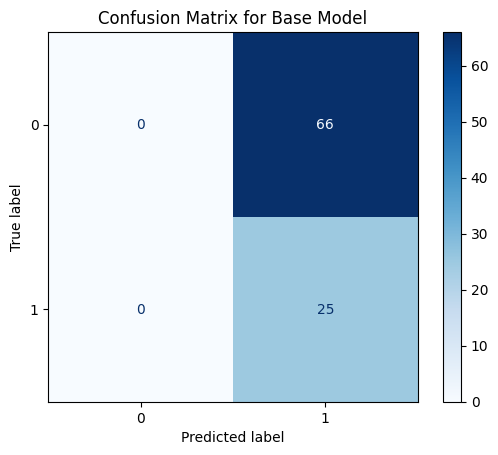

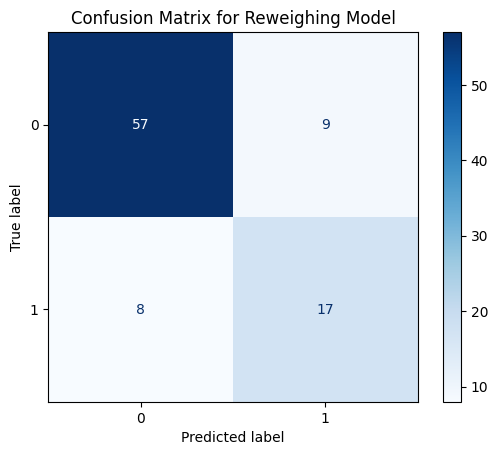

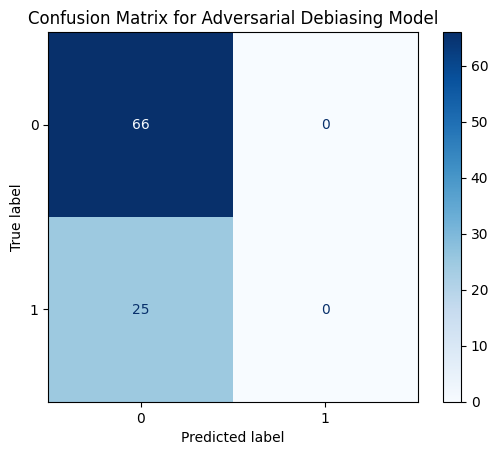

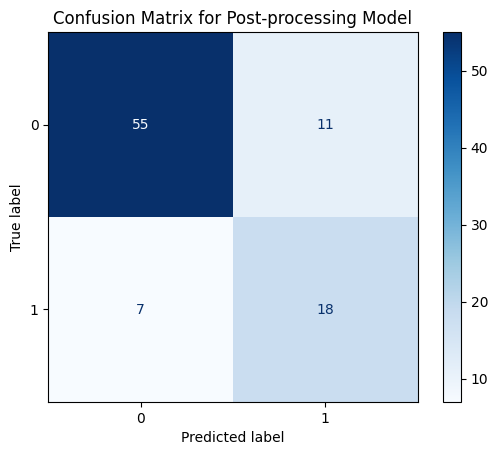

In [14]:
import seaborn as sns

# Plot comparison
comparison_df.plot(kind='bar', figsize=(12, 6), title='Comparison of Overall Metrics Before and After Bias Mitigation')
plt.ylabel('Metric Value')
plt.show()

print("Second Done")

# Comparison heatmap for overall metrics
comparison_heatmap_data = pd.DataFrame({
    'Initial': overall_metrics_initial,
    'Reweighing': overall_metrics_rw,
    'Adversarial Debiasing': overall_metrics_ad,
    'Post-processing': overall_metrics_pp
}).transpose()

plt.figure(figsize=(12, 8))
sns.heatmap(comparison_heatmap_data, annot=True, cmap='viridis', cbar=True, linewidths=0.5)
plt.title('Overall Metrics Comparison Heatmap')
plt.ylabel('Models')
plt.xlabel('Metrics')
plt.show()

# Display confusion matrix for each model
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Confusion matrices for each model
plot_confusion_matrix("Base Model", y_test, y_pred_binary)
plot_confusion_matrix("Reweighing Model", y_test, y_pred_rw)
plot_confusion_matrix("Adversarial Debiasing Model", y_test, y_pred_ad)
plot_confusion_matrix("Post-processing Model", y_test, y_pred_pp)

metrics_by_group (Base Model):                                     0  mean_absolute_error  \
racePctWhite_bin racepctblack_bin                            
0                0                NaN                  NaN   
                 1                NaN                  NaN   
                 2                NaN                  NaN   
                 3                NaN                  NaN   
                 4                NaN             0.000000   
1                0                NaN                  NaN   
                 1                NaN             0.000000   
                 2                NaN             0.000000   
                 3                NaN             1.000000   
                 4                NaN             0.000000   
2                0                NaN                  NaN   
                 1                NaN             0.000000   
                 2                NaN             0.500000   
                 3                NaN  

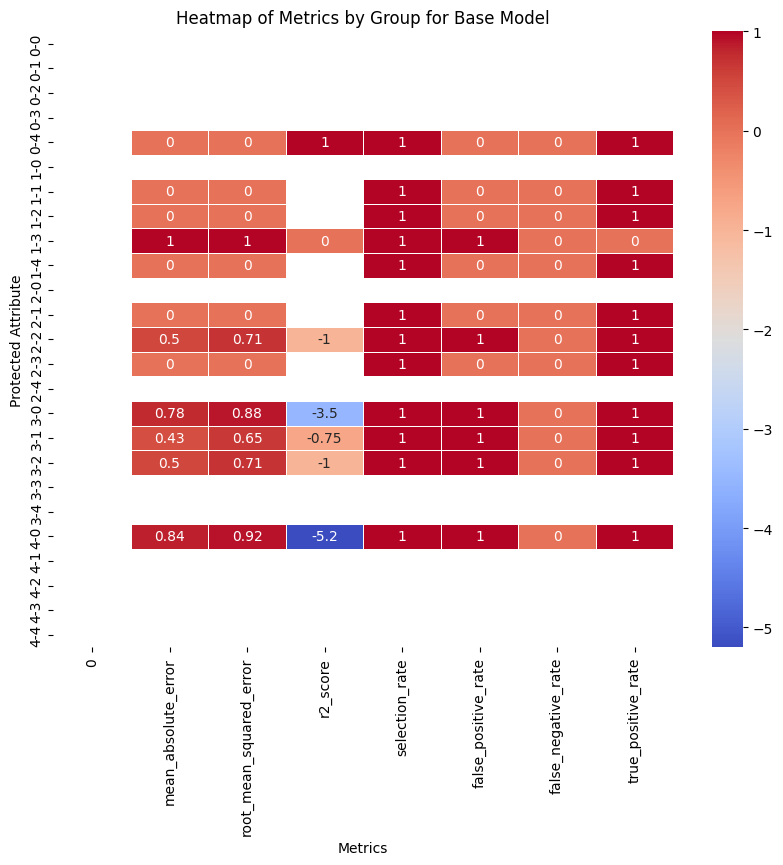

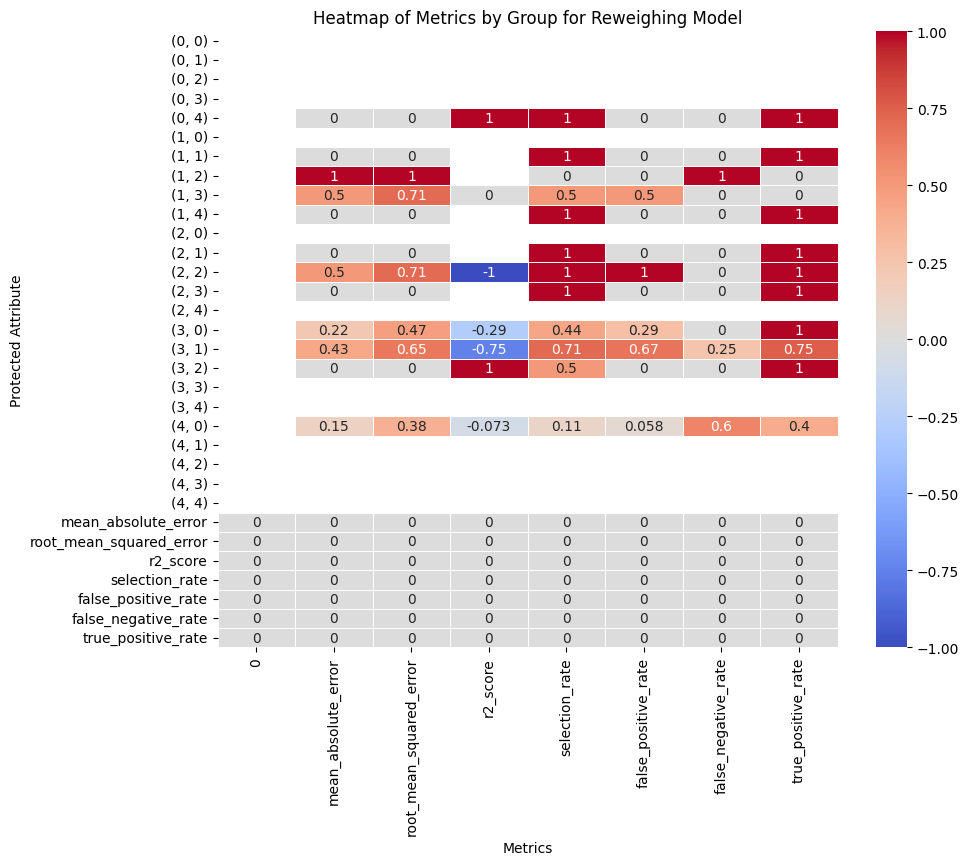

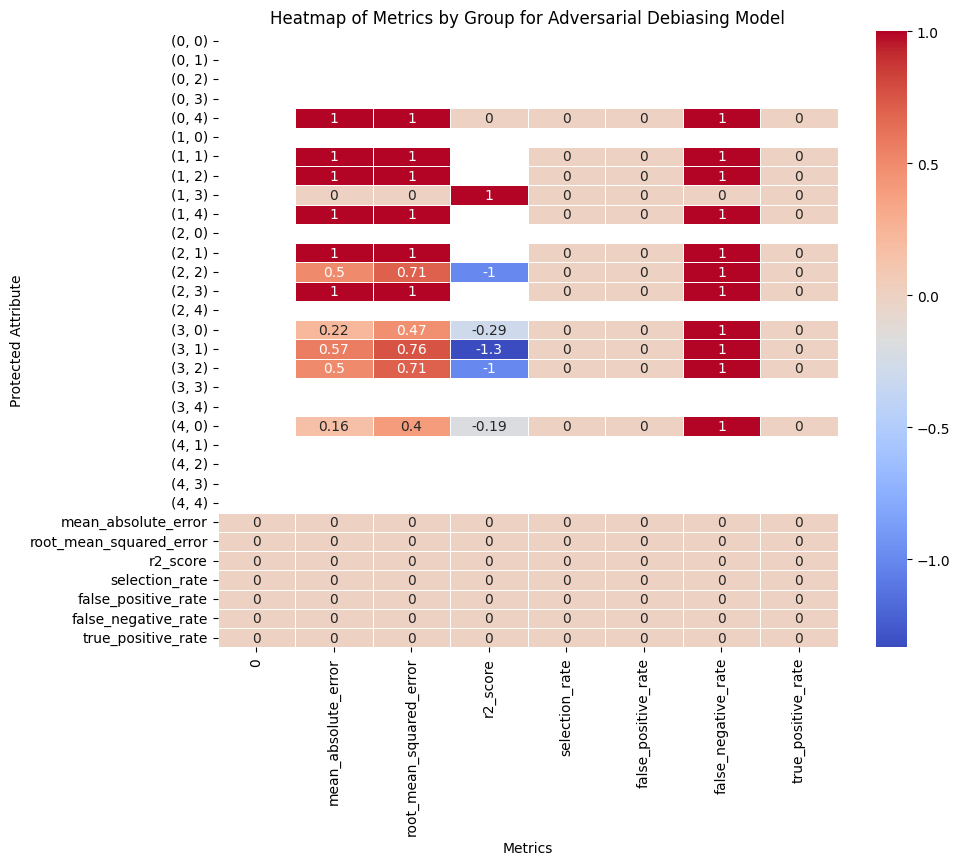

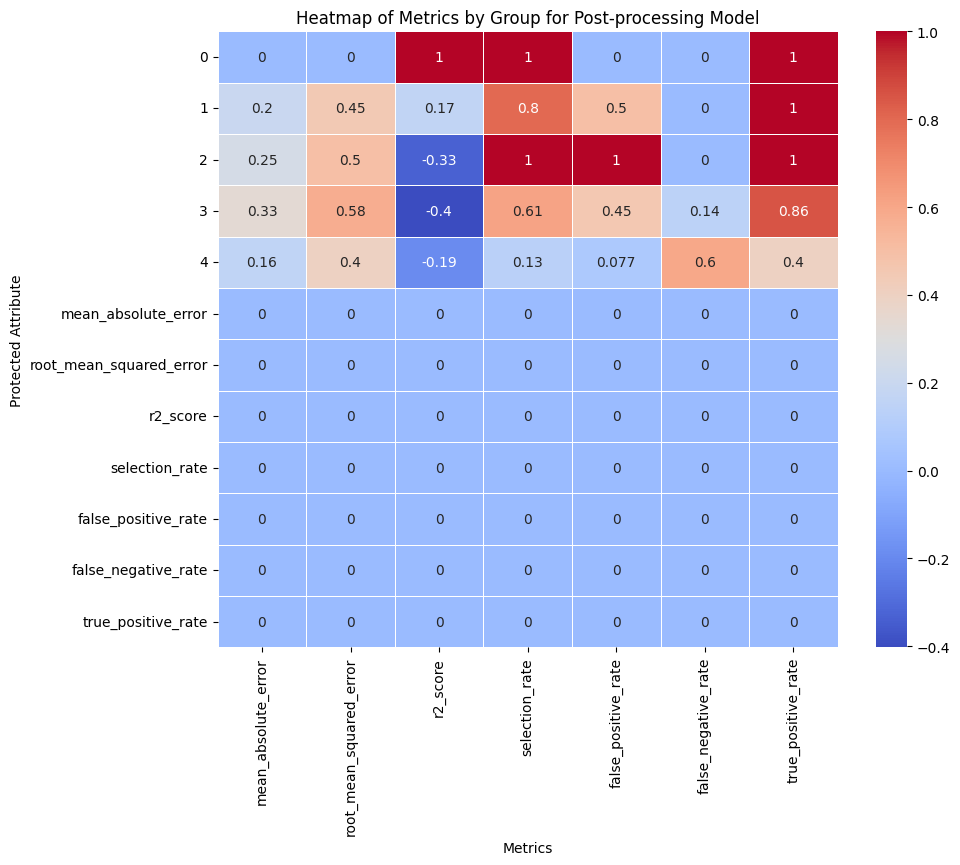

Additional confusion matrices and heatmaps done.


In [15]:
# Heatmap for each model individually
def plot_model_heatmap(model_name, metrics_by_group):
    plt.figure(figsize=(10, 8))
    sns.heatmap(metrics_by_group, annot=True, cmap='coolwarm', cbar=True, linewidths=0.5)
    plt.title(f'Heatmap of Metrics by Group for {model_name}')
    plt.ylabel('Protected Attribute')
    plt.xlabel('Metrics')
    plt.show()
    plt.close()

# Check the data structure of each metrics_by_group
print("metrics_by_group (Base Model):", metrics_by_group)
print("metrics_by_group_rw (Reweighing Model):", metrics_by_group_rw)
print("metrics_by_group_ad (Adversarial Debiasing Model):", metrics_by_group_ad)
print("metrics_by_group_pp (Post-processing Model):", metrics_by_group_pp)

# Ensure each heatmap is plotted individually
plot_model_heatmap("Base Model", pd.DataFrame(metrics_by_group))
plot_model_heatmap("Reweighing Model", pd.DataFrame(metrics_by_group_rw))
plot_model_heatmap("Adversarial Debiasing Model", pd.DataFrame(metrics_by_group_ad))
plot_model_heatmap("Post-processing Model", pd.DataFrame(metrics_by_group_pp))

print("Additional confusion matrices and heatmaps done.")
